<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled182inhibyesGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2 - Simulation Functions (ID: dRFyKIwKBfRq)
# This cell defines the core simulation functions, including the Poisson solver.

# from scipy.sparse import lil_matrix # Removed as lil_matrix is not in CuPy
# from scipy.sparse.linalg import spsolve # Removed as we are replacing scipy sparse
import numpy as np # Keep numpy import for now as we will convert incrementally
import cupy as cp # Import CuPy
import matplotlib.pyplot as plt # Import matplotlib for plotting
import matplotlib.colors as mcolors # Import mcolors for normalization
import os # Import os for directory creation
import time # Import time for performance reporting
import cupy.cuda.runtime as cuda_runtime # Import for device synchronization

# Import SciPy for building the sparse matrix on CPU
import scipy.sparse

# Import CuPy sparse and solver
# Import specific sparse matrix formats directly as suggested
# from cupy.sparse import lil_matrix # Import lil_matrix directly again (failed)
# from cupy.sparse.linalg.util import lil_matrix # Old import that failed
from cupyx.scipy.sparse import csr_matrix # Import csr_matrix for GPU
import cupy.sparse.linalg as linalg

# Reaction rates function (same as before, operating on the unified concentrations dictionary)
# Convert to use CuPy arrays
def reaction_rates_full(concentrations, rates_constants, all_species, enzyme_states_list):
    # Assuming concentrations values are CuPy arrays
    rates = {species: cp.zeros_like(concentrations['Na']) for species in all_species}

    # Extract concentrations
    c_Na = concentrations['Na']
    c_Cl = concentrations['Cl']
    c_Substrate = concentrations['Substrate']
    c_ATP = concentrations['ATP']
    c_ADP = concentrations['ADP']
    c_Pi = concentrations['Pi']
    c_Inhibitor = concentrations['Inhibitor']

    # Enzyme states
    E_Free = concentrations['Enzyme_Free']
    E_Salt = concentrations['Enzyme_SaltBound']
    E_Substrate = concentrations['Enzyme_SubstrateBound']
    E_ATP = concentrations['Enzyme_ATPBound']
    E_ADP_Pi = concentrations['Enzyme_ADP_PiBound']
    E_Inhibitor = concentrations['Enzyme_InhibitorBound']

    # --- Calculate all reaction rates first ---

    # Binding and Unbinding Reactions
    rate_E_Free_to_Salt = rates_constants['k_on_salt'] * E_Free * c_Na
    rate_E_Salt_to_Free = rates_constants['k_off_salt'] * E_Salt

    rate_E_Free_to_Substrate = rates_constants['k_on_substrate'] * E_Free * c_Substrate
    rate_E_Substrate_to_Free = rates_constants['k_off_substrate'] * E_Substrate

    rate_E_Free_to_ATP = rates_constants['k_on_ATP'] * E_Free * c_ATP
    rate_E_ATP_to_Free = rates_constants['k_off_ATP'] * E_ATP

    rate_E_Free_to_Inhibitor = rates_constants['k_on_inhibitor'] * E_Free * c_Inhibitor
    rate_E_Inhibitor_to_Free = rates_constants['k_off_inhibitor'] * E_Inhibitor

    # ATP Hydrolysis and Product Release
    rate_E_ATP_to_ADP_Pi = rates_constants['k_hydrolysis'] * E_ATP
    rate_E_ADP_Pi_to_ATP = rates_constants['k_reverse_hydrolysis'] * E_ADP_Pi # Reverse reaction is rare

    rate_E_ADP_Pi_to_Free = rates_constants['k_transition_ADP_Pi_Free'] * E_ADP_Pi


    # --- Update species rates based on calculated reaction rates ---

    # Enzyme state changes
    rates['Enzyme_Free'] += (rate_E_Salt_to_Free - rate_E_Free_to_Salt) + \
                           (rate_E_Substrate_to_Free - rate_E_Free_to_Substrate) + \
                           (rate_E_ATP_to_Free - rate_E_Free_to_ATP) + \
                           (rate_E_Inhibitor_to_Free - rate_E_Inhibitor_to_Free) + \
                           rate_E_ADP_Pi_to_Free

    rates['Enzyme_SaltBound'] += rate_E_Free_to_Salt - rate_E_Salt_to_Free

    rates['Enzyme_SubstrateBound'] += rate_E_Free_to_Substrate - rate_E_Substrate_to_Free

    rates['Enzyme_ATPBound'] += (rate_E_Free_to_ATP - rate_E_ATP_to_Free) + \
                               (rate_E_ADP_Pi_to_ATP - rate_E_ATP_to_ADP_Pi) # From Free/To Free, and from ADP_Pi/To ADP_Pi

    rates['Enzyme_ADP_PiBound'] += (rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP) - \
                                  rate_E_ADP_Pi_to_Free # From ATP/To ATP, and leaving for Free

    rates['Enzyme_InhibitorBound'] += rate_E_Free_to_Inhibitor - rate_E_Inhibitor_to_Free


    # Ligand concentration changes
    rates['Na'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Consumption/production upon binding
    rates['Cl'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Assuming coupled binding

    rates['Substrate'] += -rate_E_Free_to_Substrate + rate_E_Substrate_to_Free

    rates['ATP'] += -rate_E_Free_to_ATP + rate_E_ATP_to_Free - rate_E_ATP_to_ADP_Pi + rate_E_ADP_Pi_to_ATP
    rates['ADP'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free
    rates['Pi'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free

    rates['Inhibitor'] += -rate_E_Free_to_Inhibitor + rate_E_Inhibitor_to_Free


    return rates

# Implement a finite difference Poisson solver - Corrected approach using SciPy and CuPy CSR
def solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny):
    N_total = Ny * Nx

    # Construct the sparse matrix for the 2D Laplacian operator using SciPy's lil_matrix on the CPU
    # lil_matrix is efficient for building the matrix element by element
    A_scipy_lil = scipy.sparse.lil_matrix((N_total, N_total), dtype=np.float64) # Use numpy dtype for scipy

    # Right-hand side vector (charge density scaled by permittivity) as a CuPy array
    # Ensure charge_density is transferred to CPU for constructing b with numpy if needed,
    # or handle b construction with cupy arrays directly.
    # Since charge_density is already a CuPy array, let's keep b as CuPy.
    b = (charge_density / epsilon).ravel() # ravel flattens in row-major order

    for i in range(Ny):
        for j in range(Nx):
            row_idx = i * Nx + j

            # Apply boundary conditions: Assume fixed potential phi = 0 at boundaries for simplicity.
            if 0 < i < Ny - 1 and 0 < j < Nx - 1:
                A_scipy_lil[row_idx, row_idx] = 2.0 / dx**2 + 2.0 / dy**2
                A_scipy_lil[row_idx, row_idx + 1] = -1.0 / dx**2 # Right neighbor
                A_scipy_lil[row_idx, row_idx - 1] = -1.0 / dx**2 # Left neighbor
                A_scipy_lil[row_idx, row_idx + Nx] = -1.0 / dy**2 # Bottom neighbor
                A_scipy_lil[row_idx, row_idx - Nx] = -1.0 / dy**2 # Top neighbor
            else:
                # Boundary point: phi(i, j) = 0
                A_scipy_lil[row_idx, row_idx] = 1.0
                b[row_idx] = 0.0 # Set boundary values in the RHS vector (b is already CuPy)


    # Convert the SciPy LIL matrix to a CuPy CSR matrix for efficient GPU solving
    A_cupy_csr = csr_matrix(A_scipy_lil)

    # Solve the linear system A_cupy_csr * phi_vector = b_vector using CuPy sparse solver
    # Use the linalg.spsolve from cupy.sparse.linalg
    # b is already a CuPy array, so no transfer needed for the solver
    phi_vector = linalg.spsolve(A_cupy_csr, b)

    # Reshape the solution back to the 2D grid shape
    return phi_vector.reshape((Ny, Nx))

# Function to calculate drift terms based on electrostatic potential
# Convert to use CuPy arrays and operations
def calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species):
    drift_terms = {}
    # Use CuPy's gradient
    grad_phi_y, grad_phi_x = cp.gradient(phi, dy, dx)

    for species in all_species:
        c = concentrations[species]
        mu = mobilities[species] # mobilities is a dictionary, values are floats

        J_drift_x = -c * mu * grad_phi_x
        J_drift_y = -c * mu * grad_phi_y

        # Use CuPy's gradient for divergence
        div_J_drift = cp.gradient(J_drift_x, dx, axis=1) + cp.gradient(J_drift_y, dy, axis=0)
        drift_terms[species] = div_J_drift

    return drift_terms

# Function to calculate salt dissolution rate from flux at the crystal surface
# Convert to use CuPy arrays and operations where possible. Need to handle boundary access.
def calculate_salt_dissolution_rate(concentrations, diffusion_coefficients, mobilities, phi, dx, dy, salt_crystal_x_start, salt_crystal_x_end, salt_crystal_y_start, salt_crystal_y_end, C_salt_sat, Nx, Ny):
    flux_Na = 0
    flux_Cl = 0

    # Flux across the right boundary of the crystal (x = salt_crystal_x_end)
    if salt_crystal_x_end < Nx:
        # Accessing boundaries of CuPy arrays. Need to ensure indices are correct.
        # Using slicing for boundary values
        # Check if salt_crystal_x_end - 1 is a valid index
        if salt_crystal_x_end - 1 >= 0:
            grad_c_Na_x_boundary = (concentrations['Na'][:, salt_crystal_x_end] - concentrations['Na'][:, salt_crystal_x_end - 1]) / dx
            grad_c_Cl_x_boundary = (concentrations['Cl'][:, salt_crystal_x_end] - concentrations['Cl'][:, salt_crystal_x_end - 1]) / dx
            grad_phi_x_boundary = (phi[:, salt_crystal_x_end] - phi[:, salt_crystal_x_end - 1]) / dx

            # Calculate averages at the boundary
            c_Na_avg = (C_salt_sat + concentrations['Na'][:, salt_crystal_x_end]) / 2.0
            c_Cl_avg = (C_salt_sat + concentrations['Cl'][:, salt_crystal_x_end]) / 2.0
            # Corrected phi_avg calculation to use boundary points
            phi_avg = (phi[:, salt_crystal_x_end - 1] + phi[:, salt_crystal_x_end]) / 2.0

            J_Na_x = -diffusion_coefficients['Na'] * grad_c_Na_x_boundary - mobilities['Na'] * c_Na_avg * grad_phi_x_boundary
            J_Cl_x = -diffusion_coefficients['Cl'] * grad_c_Cl_x_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_x_boundary

            # Summing fluxes along the boundary - use CuPy sum
            flux_Na_right = cp.sum(J_Na_x[salt_crystal_y_start:salt_crystal_y_end]) * dy
            flux_Cl_right = cp.sum(J_Cl_x[salt_crystal_y_start:salt_crystal_y_end]) * dy

            flux_Na += flux_Na_right
            flux_Cl += flux_Cl_right
        else:
            # Handle case where crystal is at the very left edge (x_end = 0), no right boundary flux
            pass


    # Flux across the top boundary of the crystal (y = salt_crystal_y_end)
    if salt_crystal_y_end < Ny:
        # Accessing boundaries of CuPy arrays. Need to ensure indices are correct.
         # Check if salt_crystal_y_end - 1 is a valid index
        if salt_crystal_y_end - 1 >= 0:
            grad_c_Na_y_boundary = (concentrations['Na'][salt_crystal_y_end, :] - concentrations['Na'][salt_crystal_y_end - 1, :]) / dy
            grad_c_Cl_y_boundary = (concentrations['Cl'][salt_crystal_y_end, :] - concentrations['Cl'][salt_crystal_y_end - 1, :]) / dy
            grad_phi_y_boundary = (phi[salt_crystal_y_end, :] - phi[salt_crystal_y_end - 1, :]) / dy # Corrected tuple slicing

            c_Na_avg = (C_salt_sat + concentrations['Na'][salt_crystal_y_end, :]) / 2.0
            c_Cl_avg = (C_salt_sat + concentrations['Cl'][salt_crystal_y_end, :]) / 2.0
            # Corrected phi_avg calculation to use boundary points
            phi_avg = (phi[salt_crystal_y_end - 1, :] + phi[salt_crystal_y_end, :]) / 2.0


            J_Na_y = -diffusion_coefficients['Na'] * grad_c_Na_y_boundary - mobilities['Na'] * c_Na_avg * grad_phi_y_boundary
            J_Cl_y = -diffusion_coefficients['Cl'] * grad_c_Cl_y_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_y_boundary

            # Summing fluxes along the boundary - use CuPy sum
            flux_Na_top = cp.sum(J_Na_y[salt_crystal_x_start:salt_crystal_x_end]) * dx
            flux_Cl_top = cp.sum(J_Cl_y[salt_crystal_x_start:salt_crystal_x_end]) * dx

            flux_Na += flux_Na_top
            flux_Cl += flux_Cl_top
        else:
            # Handle case where crystal is at the very bottom edge (y_end = 0), no top boundary flux
            pass


    dissolution_rate = (flux_Na + flux_Cl) / 2.0

    # Convert the final dissolution rate back to a NumPy scalar for history
    return cp.asnumpy(dissolution_rate)

# Function to save the simulation state - Needs to handle saving CuPy arrays
def save_simulation_state(step, concentrations, cumulative_dissolved_salt, dissolution_rate_history, total_enzyme_history, output_dir="simulation_checkpoints", filename=None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # If a specific filename is provided, use it. Otherwise, generate one based on step.
    if filename:
        # If filename is a base name, join with output_dir. If it's already a path, use it.
        if not os.path.isabs(filename):
             filepath = os.path.join(output_dir, filename)
        else:
             filepath = filename # Use the absolute path if provided
    else:
        filepath = os.path.join(output_dir, f"state_step_{step}.npz")


    # Convert concentrations dictionary values from CuPy arrays to NumPy arrays for saving
    concentrations_np = {key: cp.asnumpy(value) for key, value in concentrations.items()}

    save_data = {
        'step': step,
        'cumulative_dissolved_salt': cumulative_dissolved_salt, # This should be a scalar
        'dissolution_rate_history': np.array(dissolution_rate_history), # Save as numpy array
        'total_enzyme_history': np.array(total_enzyme_history), # Assume it's always a list/array if passed
        'concentrations': concentrations_np # Save the dictionary of concentration arrays (now NumPy)
    }
    np.savez(filepath, **save_data)
    print(f"Simulation state saved at step {step} to {filepath}")

# Function to load the simulation state - Needs to load into CuPy arrays
def load_simulation_state(filename):
    if not os.path.exists(filename):
        print(f"Checkpoint file not found at {filename}")
        return None

    try:
        loaded_data = np.load(filename, allow_pickle=True) # allow_pickle=True needed for dictionaries

        # Reconstruct the concentrations dictionary and convert NumPy arrays to CuPy arrays
        loaded_concentrations_np = loaded_data['concentrations'].item() # .item() to get the dictionary
        loaded_concentrations_cp = {key: cp.asarray(value) for key, value in loaded_concentrations_np.items()}


        # Load total_enzyme_history - assume it's always present as an array if the sim included enzyme
        total_enzyme_hist = loaded_data['total_enzyme_history'].tolist() if 'total_enzyme_history' in loaded_data and loaded_data['total_enzyme_history'].size > 0 else []


        print(f"Simulation state loaded from {filename}")
        return (loaded_data['step'].item(),
                loaded_concentrations_cp, # Return CuPy concentrations
                loaded_data['cumulative_dissolved_salt'].item(),
                loaded_data['dissolution_rate_history'].tolist(), # Convert back to list
                total_enzyme_hist) # Return loaded history


    except Exception as e:
        print(f"Error loading checkpoint file {filename}: {e}")
        return None

# Helper function to create initial concentration dictionary with zeros for all species
# Needs to create CuPy arrays
def create_initial_concentrations(all_species, Ny, Nx):
    return {species: cp.zeros((Ny, Nx)) for species in all_species}


# Function to run a simulation condition (updated for checkpointing, plotting, and location args)
def run_simulation_condition_with_checkpointing(sim_name, initial_concentrations, initial_enzyme_conc=0,
                                                 enzyme_location=None,
                                                 atp_location=None, # Added specific ATP location
                                                 substrate_location=None, # Added specific Substrate location
                                                 inhibitor_location=None,
                                                 Nt=1000, dt=0.001, report_interval=500,
                                                 checkpoint_interval=1000, plot_interval=1000,
                                                 resume_all_simulations=False,
                                                 # Pass global parameters explicitly
                                                 all_species=None, enzyme_states_list=None, charges=None,
                                                 diffusion_coefficients=None, mobilities=None, epsilon=None,
                                                 rate_constants=None, Nx=None, Ny=None, dx=None, dy=None, # dx and dy passed as args
                                                 salt_crystal_x_start=None, salt_crystal_x_end=None,
                                                 salt_crystal_y_start=None, salt_crystal_y_end=None,
                                                 C_salt_sat=None, Lx=None, Ly=None): # Added Lx and Ly here

    print(f"\n--- Running simulation condition: {sim_name} ---")

    output_dir = f"simulation_results/{sim_name}"
    checkpoint_dir = f"simulation_checkpoints/{sim_name}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)


    start_step = 0
    # initial_concentrations is expected to be a dictionary of CuPy arrays now
    concentrations = initial_concentrations
    dissolution_rate_over_time = []
    cumulative_dissolved_salt = 0
    total_enzyme_over_time = [] # Track total enzyme for this simulation

    checkpoint_filename = os.path.join(checkpoint_dir, f"{sim_name}_latest_checkpoint.npz")

    if resume_all_simulations and os.path.exists(checkpoint_filename):
        print(f"Attempting to resume from checkpoint: {checkpoint_filename}")
        loaded_state = load_simulation_state(checkpoint_filename)
        if loaded_state:
            start_step, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time = loaded_state
            print(f"Resuming simulation '{sim_name}' from step {start_step}...")
        else:
            print(f"Failed to load checkpoint for '{sim_name}'. Starting from scratch.")
            # If loading failed, proceed with fresh initialization below
            start_step = 0
            # Re-initialize concentrations as CuPy arrays
            concentrations = create_initial_concentrations(all_species, Ny, Nx)


    # If starting from scratch or failed to resume, initialize concentrations based on location arguments
    if start_step == 0:
        print("Initializing concentrations...")
        # Initialize enzyme if present and enzyme_location is provided, otherwise use default
        if initial_enzyme_conc > 0:
             if enzyme_location:
                 enzyme_init_x_start, enzyme_init_x_end = enzyme_location['x_start'], enzyme_location['x_end']
                 enzyme_init_y_start, enzyme_init_y_end = enzyme_location['y_start'], enzyme_location['y_end']
             else: # Default location if none provided
                 enzyme_init_x_start, enzyme_init_x_end = int(Nx * 0.3), int(Nx * 0.4)
                 enzyme_init_y_start, enzyme_init_y_end = int(Ny * 0.3), int(Ny * 0.4)

             # Initialize on CuPy array
             concentrations['Enzyme_Free'][enzyme_init_y_start:enzyme_init_y_end, enzyme_init_x_start:enzyme_init_x_end] = initial_enzyme_conc
             # Ensure other enzyme states are zero initially
             for state in enzyme_states_list:
                 if state != 'Free':
                      concentrations[f'Enzyme_{state}'].fill(0)

        # Handle "Just ATP" initialization - Only initialize ATP
        if atp_location and 'Just_ATP' in sim_name:
             atp_init_x_start, atp_init_x_end = atp_location['x_start'], atp_location['x_end']
             atp_init_y_start, atp_init_y_end = atp_location['y_start'], atp_location['y_end']
             # Initialize on CuPy array
             concentrations['ATP'][atp_init_y_start:atp_init_y_end, atp_init_x_start:atp_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure substrate, ADP, Pi, Inhibitor are zero in Just ATP
             if 'Substrate' in concentrations: concentrations['Substrate'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle "Just Substrate" initialization - Only initialize Substrate
        elif substrate_location and 'Just_Substrate' in sim_name:
             sub_init_x_start, sub_init_x_end = substrate_location['x_start'], substrate_location['x_end']
             sub_init_y_start, sub_init_y_end = substrate_location['y_start'], substrate_location['y_end']
             # Initialize on CuPy array
             concentrations['Substrate'][sub_init_y_start:sub_init_y_end, sub_init_x_start:sub_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure initial ATP, ADP, Pi, Inhibitor are zero in Just Substrate
             if 'ATP' in concentrations: concentrations['ATP'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle combined Enzyme + Substrate + ATP and Enzyme + Substrate + ATP + Inhibitor
        # Initialize Substrate and ATP if substrate_location or atp_location is provided AND sim name matches
        elif ('Enzyme_Substrate_ATP' in sim_name): # Includes Inhibitor case
            substrate_ATP_init_concentration = 0.5 # Assuming this value
            if substrate_location:
                 sub_x_start, sub_x_end = substrate_location['x_start'], substrate_location['x_end']
                 sub_y_start, sub_y_end = substrate_location['y_start'], substrate_location['y_end']
                 if 'Substrate' in concentrations:
                    # Initialize on CuPy array
                    concentrations['Substrate'][sub_y_start:sub_y_end, sub_x_start:sub_x_end] = substrate_ATP_init_concentration

            if atp_location:
                 atp_x_start, atp_x_end = atp_location['x_start'], atp_location['x_end']
                 atp_y_start, atp_y_end = atp_location['y_start'], atp_location['y_end']
                 if 'ATP' in concentrations:
                    # Initialize on CuPy array
                    concentrations['ATP'][atp_y_start:atp_y_end, atp_x_start:atp_x_end] = substrate_ATP_init_concentration

            # Ensure initial ADP/Pi are zero in these combined cases
            if 'ADP' in concentrations: concentrations['ADP'].fill(0)
            if 'Pi' in concentrations: concentrations['Pi'].fill(0)
            # Ensure inhibitor is zero if it's not the inhibitor case
            if 'Inhibitor' in concentrations and 'Inhibitor' not in sim_name:
                 concentrations['Inhibitor'].fill(0)


        # Initialize inhibitor if present and inhibitor_location is provided AND sim name matches
        if inhibitor_location and 'Inhibitor' in sim_name:
            inhibitor_init_concentration = 0.5 # Assuming this value
            inh_x_start, inh_x_end = inhibitor_location['x_start'], inhibitor_location['x_end']
            inh_y_start, inh_y_end = inhibitor_location['y_start'], inhibitor_location['y_end']
            if 'Inhibitor' in concentrations:
                # Initialize on CuPy array - Corrected slicing
                concentrations['Inhibitor'][inh_y_start:inh_y_end, inh_x_start:inh_x_end] = inhibitor_init_concentration
            # Ensure Substrate, ATP, ADP, Pi are zero if it's just Inhibitor (though we don't have a 'Just Inhibitor' sim)
            # If it's Enzyme+Sub+ATP+Inhibitor, Substrate/ATP are initialized above, ADP/Pi are zeroed.


        # Set boundary conditions for the salt crystal: fixed concentration (applied at start and in loop)
        # Apply on CuPy arrays
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Apply boundary conditions for other walls (no flux - implicitly handled)

        # Ensure other species not explicitly initialized are zero
        for species in all_species:
             if species not in ['Na', 'Cl', 'Enzyme_Free', 'Substrate', 'ATP', 'Inhibitor'] + [f'Enzyme_{state}' for state in enzyme_states_list if state != 'Free']:
                  concentrations[species].fill(0)


    print(f"Running simulation '{sim_name}' from step {start_step} to {Nt}...")

    # Initialize timer for performance reporting
    start_time = time.time()
    last_report_step = start_step
    last_report_time = time.time()

    # Initialize CuPy events for profiling
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()


    # Simulation loop
    for t_step in range(start_step, Nt):
        # Solve Poisson equation for electrostatic potential
        start_event.record() # Start timing
        charge_density = sum(concentrations.get(species, cp.zeros_like(concentrations['Na'])) * charges.get(species, 0) for species in all_species)
        phi = solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny)
        end_event.record() # End timing
        end_event.synchronize() # Synchronize to get accurate time
        poisson_solve_time = cp.cuda.get_elapsed_time(start_event, end_event) # Time in ms

        # Add concentration check after Poisson solve
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Poisson solve at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after Poisson solve - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Calculate drift terms based on electrostatic potential
        start_event.record()
        div_drift_terms = calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species)
        end_event.record()
        end_event.synchronize()
        drift_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Drift calculation
        for species in all_species:
             # div_drift_terms are rates of change, not concentrations, check if they are NaN
             if cp.isnan(div_drift_terms[species]).any():
                  print(f"!!! NaN detected in {species} drift term after calculation at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after Drift calc - {species} drift min: {cp.min(div_drift_terms[species]).get()}, max: {cp.max(div_drift_terms[species]).get()}")


        # Calculate reaction rates (enzyme kinetics included if enzyme is present)
        start_event.record()
        rates = reaction_rates_full(concentrations, rate_constants, all_species, enzyme_states_list)
        end_event.record()
        end_event.synchronize()
        reaction_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Reaction calculation
        for species in all_species:
             # rates are rates of change, not concentrations, check if they are NaN
             if cp.isnan(rates[species]).any():
                  print(f"!!! NaN detected in {species} reaction rate after calculation at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after Reaction calc - {species} rate min: {cp.min(rates[species]).get()}, max: {cp.max(rates[species]).get()}")


        # Calculate diffusion terms for all species
        start_event.record()
        diffusion_terms = {}
        for species in all_species:
            # Use CuPy's gradient for diffusion
            grad_c_y, grad_c_x = cp.gradient(concentrations[species], dy, dx)
            laplacian_c = cp.gradient(grad_c_y, dy, axis=0) + cp.gradient(grad_c_x, dx, axis=1)
            diffusion_terms[species] = diffusion_coefficients[species] * laplacian_c
        end_event.record()
        end_event.synchronize()
        diffusion_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Diffusion calculation
        for species in all_species:
             # diffusion_terms are rates of change, not concentrations, check if they are NaN
             if cp.isnan(diffusion_terms[species]).any():
                  print(f"!!! NaN detected in {species} diffusion term after calculation at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after Diffusion calc - {species} diffusion min: {cp.min(diffusion_terms[species]).get()}, max: {cp.max(diffusion_terms[species]).get()}")


        # Update concentrations using forward Euler
        # dc/dt = Diffusion + Reaction - Divergence(Drift)
        start_event.record()
        for species in all_species:
            dcdt = diffusion_terms[species] + rates[species] - div_drift_terms[species]
            concentrations[species] += dcdt * dt

        # Add concentration check after Update
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Update at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after Update - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Apply boundary conditions for the salt crystal (fixed concentration for Na+ and Cl-)
        # Apply on CuPy arrays
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Apply boundary conditions for other walls (no flux - implicitly handled)

        # Ensure concentrations remain non-negative
        for species in all_species:
             # Use CuPy's maximum
             concentrations[species] = cp.maximum(concentrations[species], 0)
        end_event.record()
        end_event.synchronize()
        update_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Boundary Conditions and Non-negativity
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Boundary Conditions/Non-negativity at step {t_step+1} !!!")
             # Keep periodic reporting for non-NaN values
             # if (t_step + 1) % report_interval == 0:
             #      print(f"Step {t_step+1} after BC/Non-negativity - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Calculate and store salt dissolution rate
        # calculate_salt_dissolution_rate is partially converted to CuPy, returns NumPy scalar
        current_dissolution_rate = calculate_salt_dissolution_rate(
            concentrations, diffusion_coefficients, mobilities, phi, dx, dy,
            salt_crystal_x_start, salt_crystal_x_end, salt_crystal_y_start, salt_crystal_y_end, C_salt_sat, Nx, Ny
        )
        # Append only if not resuming from this point - history is loaded
        # The history lists are appended to regardless of resuming or not,
        # as the range(start_step, Nt) loop ensures we only process new steps.
        # The loaded history is already in the lists when resuming.
        dissolution_rate_over_time.append(current_dissolution_rate)
        cumulative_dissolved_salt += current_dissolution_rate * dt


        # Track total enzyme concentration if enzyme is present (or if we want to plot zero)
        # We will always calculate and track total enzyme, even if initial_enzyme_conc is 0
        # Summing CuPy arrays, convert to NumPy scalar for history
        total_enzyme = cp.sum(cp.array([concentrations.get(f'Enzyme_{state}', cp.zeros_like(concentrations['Na'])).sum().get() for state in enzyme_states_list])).get()
        total_enzyme_over_time.append(total_enzyme)


        # Periodically display simulation progress and profiling info
        if (t_step + 1) % report_interval == 0:
            current_time = time.time()
            elapsed_time = current_time - last_report_time
            steps_processed = (t_step + 1) - last_report_step
            steps_per_second = steps_processed / elapsed_time if elapsed_time > 0 else 0

            progress_msg = f"Simulation '{sim_name}': Time step {t_step+1}/{Nt} completed."
            progress_msg += f" Steps per second: {steps_per_second:.2f}"
            # Always include total enzyme in report message (already a NumPy scalar)
            current_total_enzyme = total_enzyme # Use the value already calculated for history
            progress_msg += f" Total enzyme: {current_total_enzyme:.4f}"

            # Add profiling information to the progress message (convert ms to s)
            progress_msg += f" | Profiling (ms/step): Poisson: {poisson_solve_time:.2f}, Drift: {drift_calc_time:.2f}, Reaction: {reaction_calc_time:.2f}, Diffusion: {diffusion_calc_time:.2f}, Update: {update_time:.2f}"

            print(progress_msg)

            # Update for next performance report
            last_report_step = t_step + 1
            last_report_time = current_time

        # Save checkpoint (tied to checkpoint_interval)
        if (t_step + 1) % checkpoint_interval == 0 and t_step + 1 < Nt: # Don't save checkpoint at the very end, final state is saved
            # save_simulation_state handles CuPy to NumPy conversion
            save_simulation_state(t_step + 1, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_latest_checkpoint.npz")


        # Periodically plot results (tied to plot_interval)
        if (t_step + 1) % plot_interval == 0:
             print(f"Plotting intermediate results at step {t_step+1} for simulation '{sim_name}'")
             # Pass concentrations (CuPy arrays) to plotting function, it will convert to NumPy
             # Explicitly pass Lx and Ly here
             plot_simulation_results(sim_name, dissolution_rate_over_time, total_enzyme_over_time, concentrations, t_step + 1, Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list) # Pass plotting params

    print(f"Simulation '{sim_name}' finished.")

    # Save final state
    # save_simulation_state handles CuPy to NumPy conversion
    save_simulation_state(Nt, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_final_state.npz")


# Redefine plot_simulation_results to use continuous colormaps and DISPLAY plots
# Needs to handle CuPy arrays as input for concentrations
def plot_simulation_results(sim_name, dissolution_rate_history, total_enzyme_history, final_concentrations, current_step,
                            Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list): # Added Lx and Ly here

    time_steps = np.arange(len(dissolution_rate_history)) * dt # time_steps can remain NumPy

    # Plot Salt Dissolution Rate over Time (history is already NumPy)
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, dissolution_rate_history, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Salt Dissolution Rate')
        plt.title(f'Salt Dissolution Rate Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Cumulative Dissolved Salt over Time (history is already NumPy)
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        cumulative_dissolved_salt_over_time = np.cumsum(dissolution_rate_history) * dt
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, cumulative_dissolved_salt_over_time, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Dissolved Salt')
        plt.title(f'Cumulative Dissolved Salt Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Total Enzyme Concentration over Time (history is already NumPy)
    # The history will be an empty list or all zeros if no enzyme was initialized
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, total_enzyme_history, label=sim_name)
    plt.xlabel('Time')
    plt.ylabel('Total Enzyme Concentration (Sum over states and grid)')
    plt.title(f'Total Enzyme Concentration Over Time: {sim_name} (Step {current_step})')
    plt.legend()
    plt.grid(True)
    plt.show() # Display plot
    plt.close() # Close the figure


    # Plot spatial distributions (or current distributions at checkpoint)
    print(f"Generating spatial distributions for '{sim_name}' at step {current_step}...")

    # Calculate total enzyme concentration - ensure conversion to NumPy for plotting
    total_enzyme_concentration_cp = cp.sum(cp.array([final_concentrations.get(f'Enzyme_{state}', cp.zeros((Ny, Nx))) for state in enzyme_states_list]), axis=0)
    total_enzyme_concentration_np = cp.asnumpy(total_enzyme_concentration_cp)


    # Define a list of species to plot spatial distributions for and their preferred continuous colormaps
    species_to_plot_spatial = {
        'Na': 'hot',
        'Cl': 'hot',
        'ATP': 'viridis',
        'Substrate': 'viridis',
        'Inhibitor': 'plasma'
    }

    # Using current state min/max for color scaling within this plot call - calculate from CuPy arrays
    current_state_min_max = {}
    # --- Incorporate user's suggestion for iterating over a list ---
    species_list_for_plotting = list(species_to_plot_spatial.keys()) # Create a list from the dictionary keys

    for species in species_list_for_plotting: # Iterate over the list
        if species in final_concentrations and final_concentrations[species].size > 0:
            # Use CuPy min/max, then convert to NumPy scalars
            c_min, c_max = final_concentrations[species].min().get(), final_concentrations[species].max().get()
            if c_min == c_max: # Avoid division by zero if concentration is uniform
                c_max += 1e-9
            current_state_min_max[species] = (c_min, c_max)
        else:
             current_state_min_max[species] = (0, 1e-9) # Default if species not present or all zero
    # --- End of user's suggestion incorporation ---


    # Min/max for Total Enzyme (always calculate min/max even if all zeros) - from NumPy array
    if total_enzyme_concentration_np.size > 0:
         e_min, e_max = total_enzyme_concentration_np.min(), total_enzyme_concentration_np.max()
         if e_min == e_max:
             e_max += 1e-9
         current_state_min_max['Total_Enzyme'] = (e_min, e_max)
    else:
        current_state_min_max['Total_Enzyme'] = (0, 1e-9)


    # Determine which species are actually present in this simulation's final concentrations
    # and are in our list of species to plot
    # Use the species_list_for_plotting for determining presence
    present_spatial_species = [species for species in species_list_for_plotting if species in final_concentrations]
    # Always plot total enzyme spatial distribution
    plot_total_enzyme_spatial = True


    num_spatial_plots = len(present_spatial_species) + (1 if plot_total_enzyme_spatial else 0)

    # Skip plotting spatial distributions if there are no species to plot
    if num_spatial_plots == 0:
         print(f"No relevant species concentrations found for generating spatial distributions for '{sim_name}'. Skipping spatial plots.")
         return


    fig, axes = plt.subplots(1, num_spatial_plots, figsize=(num_spatial_plots * 6, 6))

    # Ensure axes is an array even if there's only one subplot
    if num_spatial_plots == 1:
        axes = [axes]

    plot_idx = 0

    # Plot Total Enzyme Concentration (spatial distribution - always plot) - use NumPy array
    vmin, vmax = current_state_min_max['Total_Enzyme']
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_enzyme = 'viridis'

    # Add debugging prints for Total Enzyme
    # print(f"--- Plotting Total Enzyme for {sim_name} ---")
    # # Convert CuPy array to NumPy array here explicitly before printing/plotting
    # total_enzyme_concentration_plot_np = cp.asnumpy(total_enzyme_concentration_cp)
    # print(f"Total Enzyme array shape: {total_enzyme_concentration_plot_np.shape}")
    # print(f"Total Enzyme min: {vmin}, max: {vmax}")
    # print(f"Total Enzyme first 5x5 block:\n{total_enzyme_concentration_plot_np[:5, :5]}")
    # print("-" * 30)


    im = axes[plot_idx].imshow(total_enzyme_concentration_np, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap_enzyme, norm=norm)
    fig.colorbar(im, ax=axes[plot_idx], label='Total Enzyme Concentration')
    axes[plot_idx].set_title(f'{sim_name}\nTotal Enzyme Distribution')
    axes[plot_idx].set_xlabel('x')
    axes[plot_idx].set_ylabel('y')
    axes[plot_idx].set_aspect('equal', adjustable='box')
    plot_idx += 1


    # Plot spatial distribution for each selected species - convert from CuPy to NumPy for plotting
    for species in present_spatial_species:
        vmin, vmax = current_state_min_max[species]
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        # Use the species_to_plot_spatial dictionary for colormap
        cmap = species_to_plot_spatial[species] # Get the colormap name

        # Add debugging prints for each species
        # print(f"--- Plotting {species} for {sim_name} ---")
        # # Convert CuPy array to NumPy array here explicitly before printing/plotting
        # species_concentration_np = cp.asnumpy(final_concentrations[species])
        # print(f"{species} array shape: {species_concentration_np.shape}")
        # print(f"{species} min: {vmin}, max: {vmax}")
        # print(f"{species} first 5x5 block:\n{species_concentration_np[:5, :5]}")
        # print("-" * 30)


        im = axes[plot_idx].imshow(cp.asnumpy(final_concentrations[species]), extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap, norm=norm)
        fig.colorbar(im, ax=axes[plot_idx], label='Concentration')

        axes[plot_idx].set_title(f'{sim_name}\n{species} Concentration Distribution')
        axes[plot_idx].set_xlabel('x')
        axes[plot_idx].set_ylabel('y')
        axes[plot_idx].set_aspect('equal', adjustable='box')
        plot_idx += 1


    plt.tight_layout()
    plt.show() # Display plot
    plt.close() # Close the figure

print("Simulation functions (including plotting with debugging prints) defined and partially converted to CuPy.")

Simulation functions (including plotting with debugging prints) defined and partially converted to CuPy.


In [ ]:
# Cell 2 - Simulation Functions (ID: dRFyKIwKBfRq)
# This cell defines the core simulation functions, including the Poisson solver.

# from scipy.sparse import lil_matrix # Removed as lil_matrix is not in CuPy
# from scipy.sparse.linalg import spsolve # Removed as we are replacing scipy sparse
import numpy as np # Keep numpy import for now as we will convert incrementally
import cupy as cp # Import CuPy
import matplotlib.pyplot as plt # Import matplotlib for plotting
import matplotlib.colors as mcolors # Import mcolors for normalization
import os # Import os for directory creation
import time # Import time for performance reporting
import cupy.cuda.runtime as cuda_runtime # Import for device synchronization

# Import SciPy for building the sparse matrix on CPU
import scipy.sparse

# Import CuPy sparse and solver
# Import specific sparse matrix formats directly as suggested
# from cupy.sparse import lil_matrix # Import lil_matrix directly again (failed)
# from cupy.sparse.linalg.util import lil_matrix # Old import that failed
from cupyx.scipy.sparse import csr_matrix # Import csr_matrix for GPU
import cupy.sparse.linalg as linalg

# Reaction rates function (same as before, operating on the unified concentrations dictionary)
# Convert to use CuPy arrays
def reaction_rates_full(concentrations, rates_constants, all_species, enzyme_states_list):
    # Assuming concentrations values are CuPy arrays
    rates = {species: cp.zeros_like(concentrations['Na']) for species in all_species}

    # Extract concentrations
    c_Na = concentrations['Na']
    c_Cl = concentrations['Cl']
    c_Substrate = concentrations['Substrate']
    c_ATP = concentrations['ATP']
    c_ADP = concentrations['ADP']
    c_Pi = concentrations['Pi']
    c_Inhibitor = concentrations['Inhibitor']

    # Enzyme states
    E_Free = concentrations['Enzyme_Free']
    E_Salt = concentrations['Enzyme_SaltBound']
    E_Substrate = concentrations['Enzyme_SubstrateBound']
    E_ATP = concentrations['Enzyme_ATPBound']
    E_ADP_Pi = concentrations['Enzyme_ADP_PiBound']
    E_Inhibitor = concentrations['Enzyme_InhibitorBound']

    # --- Calculate all reaction rates first ---

    # Binding and Unbinding Reactions
    rate_E_Free_to_Salt = rates_constants['k_on_salt'] * E_Free * c_Na
    rate_E_Salt_to_Free = rates_constants['k_off_salt'] * E_Salt

    rate_E_Free_to_Substrate = rates_constants['k_on_substrate'] * E_Free * c_Substrate
    rate_E_Substrate_to_Free = rates_constants['k_off_substrate'] * E_Substrate

    rate_E_Free_to_ATP = rates_constants['k_on_ATP'] * E_Free * c_ATP
    rate_E_ATP_to_Free = rates_constants['k_off_ATP'] * E_ATP

    rate_E_Free_to_Inhibitor = rates_constants['k_on_inhibitor'] * E_Free * c_Inhibitor
    rate_E_Inhibitor_to_Free = rates_constants['k_off_inhibitor'] * E_Inhibitor

    # ATP Hydrolysis and Product Release
    rate_E_ATP_to_ADP_Pi = rates_constants['k_hydrolysis'] * E_ATP
    rate_E_ADP_Pi_to_ATP = rates_constants['k_reverse_hydrolysis'] * E_ADP_Pi # Reverse reaction is rare

    rate_E_ADP_Pi_to_Free = rates_constants['k_transition_ADP_Pi_Free'] * E_ADP_Pi


    # --- Update species rates based on calculated reaction rates ---

    # Enzyme state changes
    rates['Enzyme_Free'] += (rate_E_Salt_to_Free - rate_E_Free_to_Salt) + \
                           (rate_E_Substrate_to_Free - rate_E_Free_to_Substrate) + \
                           (rate_E_ATP_to_Free - rate_E_Free_to_ATP) + \
                           (rate_E_Inhibitor_to_Free - rate_E_Inhibitor_to_Free) + \
                           rate_E_ADP_Pi_to_Free

    rates['Enzyme_SaltBound'] += rate_E_Free_to_Salt - rate_E_Salt_to_Free

    rates['Enzyme_SubstrateBound'] += rate_E_Free_to_Substrate - rate_E_Substrate_to_Free

    rates['Enzyme_ATPBound'] += (rate_E_Free_to_ATP - rate_E_ATP_to_Free) + \
                               (rate_E_ADP_Pi_to_ATP - rate_E_ATP_to_ADP_Pi) # From Free/To Free, and from ADP_Pi/To ADP_Pi

    rates['Enzyme_ADP_PiBound'] += (rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP) - \
                                  rate_E_ADP_Pi_to_Free # From ATP/To ATP, and leaving for Free

    rates['Enzyme_InhibitorBound'] += rate_E_Free_to_Inhibitor - rate_E_Inhibitor_to_Free


    # Ligand concentration changes
    rates['Na'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Consumption/production upon binding
    rates['Cl'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Assuming coupled binding

    rates['Substrate'] += -rate_E_Free_to_Substrate + rate_E_Substrate_to_Free

    rates['ATP'] += -rate_E_Free_to_ATP + rate_E_ATP_to_Free - rate_E_ATP_to_ADP_Pi + rate_E_ADP_Pi_to_ATP
    rates['ADP'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free
    rates['Pi'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free

    rates['Inhibitor'] += -rate_E_Free_to_Inhibitor + rate_E_Inhibitor_to_Free


    return rates

# Implement a finite difference Poisson solver - Corrected approach using SciPy and CuPy CSR
def solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny):
    N_total = Ny * Nx

    # Construct the sparse matrix for the 2D Laplacian operator using SciPy's lil_matrix on the CPU
    # lil_matrix is efficient for building the matrix element by element
    A_scipy_lil = scipy.sparse.lil_matrix((N_total, N_total), dtype=np.float64) # Use numpy dtype for scipy

    # Right-hand side vector (charge density scaled by permittivity) as a CuPy array
    # Ensure charge_density is transferred to CPU for constructing b with numpy if needed,
    # or handle b construction with cupy arrays directly.
    # Since charge_density is already a CuPy array, let's keep b as CuPy.
    b = (charge_density / epsilon).ravel() # ravel flattens in row-major order

    for i in range(Ny):
        for j in range(Nx):
            row_idx = i * Nx + j

            # Apply boundary conditions: Assume fixed potential phi = 0 at boundaries for simplicity.
            if 0 < i < Ny - 1 and 0 < j < Nx - 1:
                A_scipy_lil[row_idx, row_idx] = 2.0 / dx**2 + 2.0 / dy**2
                A_scipy_lil[row_idx, row_idx + 1] = -1.0 / dx**2 # Right neighbor
                A_scipy_lil[row_idx, row_idx - 1] = -1.0 / dx**2 # Left neighbor
                A_scipy_lil[row_idx, row_idx + Nx] = -1.0 / dy**2 # Bottom neighbor
                A_scipy_lil[row_idx, row_idx - Nx] = -1.0 / dy**2 # Top neighbor
            else:
                # Boundary point: phi(i, j) = 0
                A_scipy_lil[row_idx, row_idx] = 1.0
                b[row_idx] = 0.0 # Set boundary values in the RHS vector (b is already CuPy)


    # Convert the SciPy LIL matrix to a CuPy CSR matrix for efficient GPU solving
    A_cupy_csr = csr_matrix(A_scipy_lil)

    # Solve the linear system A_cupy_csr * phi_vector = b_vector using CuPy sparse solver
    # Use the linalg.spsolve from cupy.sparse.linalg
    # b is already a CuPy array, so no transfer needed for the solver
    phi_vector = linalg.spsolve(A_cupy_csr, b)

    # Reshape the solution back to the 2D grid shape
    return phi_vector.reshape((Ny, Nx))

# Function to calculate drift terms based on electrostatic potential
# Convert to use CuPy arrays and operations
def calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species):
    drift_terms = {}
    # Use CuPy's gradient
    grad_phi_y, grad_phi_x = cp.gradient(phi, dy, dx)

    for species in all_species:
        c = concentrations[species]
        mu = mobilities[species] # mobilities is a dictionary, values are floats

        J_drift_x = -c * mu * grad_phi_x
        J_drift_y = -c * mu * grad_phi_y

        # Use CuPy's gradient for divergence
        div_J_drift = cp.gradient(J_drift_x, dx, axis=1) + cp.gradient(J_drift_y, dy, axis=0)
        drift_terms[species] = div_J_drift

    return drift_terms

# Function to calculate salt dissolution rate from flux at the crystal surface
# Convert to use CuPy arrays and operations where possible. Need to handle boundary access.
def calculate_salt_dissolution_rate(concentrations, diffusion_coefficients, mobilities, phi, dx, dy, salt_crystal_x_start, salt_crystal_x_end, salt_crystal_y_start, salt_crystal_y_end, C_salt_sat, Nx, Ny):
    flux_Na = 0
    flux_Cl = 0

    # Flux across the right boundary of the crystal (x = salt_crystal_x_end)
    if salt_crystal_x_end < Nx:
        # Accessing boundaries of CuPy arrays. Need to ensure indices are correct.
        # Using slicing for boundary values
        # Check if salt_crystal_x_end - 1 is a valid index
        if salt_crystal_x_end - 1 >= 0:
            grad_c_Na_x_boundary = (concentrations['Na'][:, salt_crystal_x_end] - concentrations['Na'][:, salt_crystal_x_end - 1]) / dx
            grad_c_Cl_x_boundary = (concentrations['Cl'][:, salt_crystal_x_end] - concentrations['Cl'][:, salt_crystal_x_end - 1]) / dx
            grad_phi_x_boundary = (phi[:, salt_crystal_x_end] - phi[:, salt_crystal_x_end - 1]) / dx

            # Calculate averages at the boundary
            c_Na_avg = (C_salt_sat + concentrations['Na'][:, salt_crystal_x_end]) / 2.0
            c_Cl_avg = (C_salt_sat + concentrations['Cl'][:, salt_crystal_x_end]) / 2.0
            # Corrected phi_avg calculation to use boundary points
            phi_avg = (phi[:, salt_crystal_x_end - 1] + phi[:, salt_crystal_x_end]) / 2.0

            J_Na_x = -diffusion_coefficients['Na'] * grad_c_Na_x_boundary - mobilities['Na'] * c_Na_avg * grad_phi_x_boundary
            J_Cl_x = -diffusion_coefficients['Cl'] * grad_c_Cl_x_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_x_boundary

            # Summing fluxes along the boundary - use CuPy sum
            flux_Na_right = cp.sum(J_Na_x[salt_crystal_y_start:salt_crystal_y_end]) * dy
            flux_Cl_right = cp.sum(J_Cl_x[salt_crystal_y_start:salt_crystal_y_end]) * dy

            flux_Na += flux_Na_right
            flux_Cl += flux_Cl_right
        else:
            # Handle case where crystal is at the very left edge (x_end = 0), no right boundary flux
            pass


    # Flux across the top boundary of the crystal (y = salt_crystal_y_end)
    if salt_crystal_y_end < Ny:
        # Accessing boundaries of CuPy arrays. Need to ensure indices are correct.
         # Check if salt_crystal_y_end - 1 is a valid index
        if salt_crystal_y_end - 1 >= 0:
            grad_c_Na_y_boundary = (concentrations['Na'][salt_crystal_y_end, :] - concentrations['Na'][salt_crystal_y_end - 1, :]) / dy
            grad_c_Cl_y_boundary = (concentrations['Cl'][salt_crystal_y_end, :] - concentrations['Cl'][salt_crystal_y_end - 1, :]) / dy
            grad_phi_y_boundary = (phi[salt_crystal_y_end, :] - phi[salt_crystal_y_end - 1, :]) / dy # Corrected tuple slicing

            c_Na_avg = (C_salt_sat + concentrations['Na'][salt_crystal_y_end, :]) / 2.0
            c_Cl_avg = (C_salt_sat + concentrations['Cl'][salt_crystal_y_end, :]) / 2.0
            # Corrected phi_avg calculation to use boundary points
            phi_avg = (phi[salt_crystal_y_end - 1, :] + phi[salt_crystal_y_end, :]) / 2.0


            J_Na_y = -diffusion_coefficients['Na'] * grad_c_Na_y_boundary - mobilities['Na'] * c_Na_avg * grad_phi_y_boundary
            J_Cl_y = -diffusion_coefficients['Cl'] * grad_c_Cl_y_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_y_boundary

            # Summing fluxes along the boundary - use CuPy sum
            flux_Na_top = cp.sum(J_Na_y[salt_crystal_x_start:salt_crystal_x_end]) * dx
            flux_Cl_top = cp.sum(J_Cl_y[salt_crystal_x_start:salt_crystal_x_end]) * dx

            flux_Na += flux_Na_top
            flux_Cl += flux_Cl_top
        else:
            # Handle case where crystal is at the very bottom edge (y_end = 0), no top boundary flux
            pass


    dissolution_rate = (flux_Na + flux_Cl) / 2.0

    # Convert the final dissolution rate back to a NumPy scalar for history
    return cp.asnumpy(dissolution_rate)

# Function to save the simulation state - Needs to handle saving CuPy arrays
def save_simulation_state(step, concentrations, cumulative_dissolved_salt, dissolution_rate_history, total_enzyme_history, output_dir="simulation_checkpoints", filename=None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # If a specific filename is provided, use it. Otherwise, generate one based on step.
    if filename:
        # If filename is a base name, join with output_dir. If it's already a path, use it.
        if not os.path.isabs(filename):
             filepath = os.path.join(output_dir, filename)
        else:
             filepath = filename # Use the absolute path if provided
    else:
        filepath = os.path.join(output_dir, f"state_step_{step}.npz")


    # Convert concentrations dictionary values from CuPy arrays to NumPy arrays for saving
    concentrations_np = {key: cp.asnumpy(value) for key, value in concentrations.items()}

    save_data = {
        'step': step,
        'cumulative_dissolved_salt': cumulative_dissolved_salt, # This should be a scalar
        'dissolution_rate_history': np.array(dissolution_rate_history), # Save as numpy array
        'total_enzyme_history': np.array(total_enzyme_history), # Assume it's always a list/array if passed
        'concentrations': concentrations_np # Save the dictionary of concentration arrays (now NumPy)
    }
    np.savez(filepath, **save_data)
    print(f"Simulation state saved at step {step} to {filepath}")

# Function to load the simulation state - Needs to load into CuPy arrays
def load_simulation_state(filename):
    if not os.path.exists(filename):
        print(f"Checkpoint file not found at {filename}")
        return None

    try:
        loaded_data = np.load(filename, allow_pickle=True) # allow_pickle=True needed for dictionaries

        # Reconstruct the concentrations dictionary and convert NumPy arrays to CuPy arrays
        loaded_concentrations_np = loaded_data['concentrations'].item() # .item() to get the dictionary
        loaded_concentrations_cp = {key: cp.asarray(value) for key, value in loaded_concentrations_np.items()}


        # Load total_enzyme_history - assume it's always present as an array if the sim included enzyme
        total_enzyme_hist = loaded_data['total_enzyme_history'].tolist() if 'total_enzyme_history' in loaded_data and loaded_data['total_enzyme_history'].size > 0 else []


        print(f"Simulation state loaded from {filename}")
        return (loaded_data['step'].item(),
                loaded_concentrations_cp, # Return CuPy concentrations
                loaded_data['cumulative_dissolved_salt'].item(),
                loaded_data['dissolution_rate_history'].tolist(), # Convert back to list
                total_enzyme_hist) # Return loaded history


    except Exception as e:
        print(f"Error loading checkpoint file {filename}: {e}")
        return None

# Helper function to create initial concentration dictionary with zeros for all species
# Needs to create CuPy arrays
def create_initial_concentrations(all_species, Ny, Nx):
    return {species: cp.zeros((Ny, Nx)) for species in all_species}


# Function to run a simulation condition (updated for checkpointing, plotting, and location args)
def run_simulation_condition_with_checkpointing(sim_name, initial_concentrations, initial_enzyme_conc=0,
                                                 enzyme_location=None,
                                                 atp_location=None, # Added specific ATP location
                                                 substrate_location=None, # Added specific Substrate location
                                                 inhibitor_location=None,
                                                 Nt=1000, dt=0.001, report_interval=500,
                                                 checkpoint_interval=1000, plot_interval=1000,
                                                 resume_all_simulations=False,
                                                 # Pass global parameters explicitly
                                                 all_species=None, enzyme_states_list=None, charges=None,
                                                 diffusion_coefficients=None, mobilities=None, epsilon=None,
                                                 rate_constants=None, Nx=None, Ny=None, dx=dx, dy=dy,
                                                 salt_crystal_x_start=None, salt_crystal_x_end=None,
                                                 salt_crystal_y_start=None, salt_crystal_y_end=None,
                                                 C_salt_sat=None):

    print(f"\n--- Running simulation condition: {sim_name} ---")

    output_dir = f"simulation_results/{sim_name}"
    checkpoint_dir = f"simulation_checkpoints/{sim_name}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)


    start_step = 0
    # initial_concentrations is expected to be a dictionary of CuPy arrays now
    concentrations = initial_concentrations
    dissolution_rate_over_time = []
    cumulative_dissolved_salt = 0
    total_enzyme_over_time = [] # Track total enzyme for this simulation

    checkpoint_filename = os.path.join(checkpoint_dir, f"{sim_name}_latest_checkpoint.npz")

    if resume_all_simulations and os.path.exists(checkpoint_filename):
        print(f"Attempting to resume from checkpoint: {checkpoint_filename}")
        loaded_state = load_simulation_state(checkpoint_filename)
        if loaded_state:
            start_step, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time = loaded_state
            print(f"Resuming simulation '{sim_name}' from step {start_step}...")
        else:
            print(f"Failed to load checkpoint for '{sim_name}'. Starting from scratch.")
            # If loading failed, proceed with fresh initialization below
            start_step = 0
            # Re-initialize concentrations as CuPy arrays
            concentrations = create_initial_concentrations(all_species, Ny, Nx)


    # If starting from scratch or failed to resume, initialize concentrations based on location arguments
    if start_step == 0:
        print("Initializing concentrations...")
        # Initialize enzyme if present and enzyme_location is provided, otherwise use default
        if initial_enzyme_conc > 0:
             if enzyme_location:
                 enzyme_init_x_start, enzyme_init_x_end = enzyme_location['x_start'], enzyme_location['x_end']
                 enzyme_init_y_start, enzyme_init_y_end = enzyme_location['y_start'], enzyme_location['y_end']
             else: # Default location if none provided
                 enzyme_init_x_start, enzyme_init_x_end = int(Nx * 0.3), int(Nx * 0.4)
                 enzyme_init_y_start, enzyme_init_y_end = int(Ny * 0.3), int(Ny * 0.4)

             # Initialize on CuPy array
             concentrations['Enzyme_Free'][enzyme_init_y_start:enzyme_init_y_end, enzyme_init_x_start:enzyme_init_x_end] = initial_enzyme_conc
             # Ensure other enzyme states are zero initially
             for state in enzyme_states_list:
                 if state != 'Free':
                      concentrations[f'Enzyme_{state}'].fill(0)

        # Handle "Just ATP" initialization - Only initialize ATP
        if atp_location and 'Just_ATP' in sim_name:
             atp_init_x_start, atp_init_x_end = atp_location['x_start'], atp_location['x_end']
             atp_init_y_start, atp_init_y_end = atp_location['y_start'], atp_location['y_end']
             # Initialize on CuPy array
             concentrations['ATP'][atp_init_y_start:atp_init_y_end, atp_init_x_start:atp_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure substrate, ADP, Pi, Inhibitor are zero in Just ATP
             if 'Substrate' in concentrations: concentrations['Substrate'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle "Just Substrate" initialization - Only initialize Substrate
        elif substrate_location and 'Just_Substrate' in sim_name:
             sub_init_x_start, sub_init_x_end = substrate_location['x_start'], substrate_location['x_end']
             sub_init_y_start, sub_init_y_end = substrate_location['y_start'], substrate_location['y_end']
             # Initialize on CuPy array
             concentrations['Substrate'][sub_init_y_start:sub_init_y_end, sub_init_x_start:sub_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure initial ATP, ADP, Pi, Inhibitor are zero in Just Substrate
             if 'ATP' in concentrations: concentrations['ATP'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle combined Enzyme + Substrate + ATP and Enzyme + Substrate + ATP + Inhibitor
        # Initialize Substrate and ATP if substrate_location or atp_location is provided AND sim name matches
        elif ('Enzyme_Substrate_ATP' in sim_name): # Includes Inhibitor case
            substrate_ATP_init_concentration = 0.5 # Assuming this value
            if substrate_location:
                 sub_x_start, sub_x_end = substrate_location['x_start'], substrate_location['x_end']
                 sub_y_start, sub_y_end = substrate_location['y_start'], substrate_location['y_end']
                 if 'Substrate' in concentrations:
                    # Initialize on CuPy array
                    concentrations['Substrate'][sub_y_start:sub_y_end, sub_x_start:sub_x_end] = substrate_ATP_init_concentration

            if atp_location:
                 atp_x_start, atp_x_end = atp_location['x_start'], atp_location['x_end']
                 atp_y_start, atp_y_end = atp_location['y_start'], atp_location['y_end']
                 if 'ATP' in concentrations:
                    # Initialize on CuPy array
                    concentrations['ATP'][atp_y_start:atp_y_end, atp_x_start:atp_x_end] = substrate_ATP_init_concentration

            # Ensure initial ADP/Pi are zero in these combined cases
            if 'ADP' in concentrations: concentrations['ADP'].fill(0)
            if 'Pi' in concentrations: concentrations['Pi'].fill(0)
            # Ensure inhibitor is zero if it's not the inhibitor case
            if 'Inhibitor' in concentrations and 'Inhibitor' not in sim_name:
                 concentrations['Inhibitor'].fill(0)


        # Initialize inhibitor if present and inhibitor_location is provided AND sim name matches
        if inhibitor_location and 'Inhibitor' in sim_name:
            inhibitor_init_concentration = 0.5 # Assuming this value
            inh_x_start, inh_x_end = inhibitor_location['x_start'], inhibitor_location['x_end']
            inh_y_start, inh_y_end = inhibitor_location['y_start'], inhibitor_location['y_end']
            if 'Inhibitor' in concentrations:
                # Initialize on CuPy array - Corrected slicing
                concentrations['Inhibitor'][inh_y_start:inh_y_end, inh_x_start:inh_x_end] = inhibitor_init_concentration
            # Ensure Substrate, ATP, ADP, Pi are zero if it's just Inhibitor (though we don't have a 'Just Inhibitor' sim)
            # If it's Enzyme+Sub+ATP+Inhibitor, Substrate/ATP are initialized above, ADP/Pi are zeroed.


        # Set boundary conditions for the salt crystal: fixed concentration (applied at start and in loop)
        # Apply on CuPy arrays
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Apply boundary conditions for other walls (no flux - implicitly handled)

        # Ensure other species not explicitly initialized are zero
        for species in all_species:
             if species not in ['Na', 'Cl', 'Enzyme_Free', 'Substrate', 'ATP', 'Inhibitor'] + [f'Enzyme_{state}' for state in enzyme_states_list if state != 'Free']:
                  concentrations[species].fill(0)


    print(f"Running simulation '{sim_name}' from step {start_step} to {Nt}...")

    # Initialize timer for performance reporting
    start_time = time.time()
    last_report_step = start_step
    last_report_time = time.time()

    # Initialize CuPy events for profiling
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()


    # Simulation loop
    for t_step in range(start_step, Nt):
        # Solve Poisson equation for electrostatic potential
        start_event.record() # Start timing
        charge_density = sum(concentrations.get(species, cp.zeros_like(concentrations['Na'])) * charges.get(species, 0) for species in all_species)
        phi = solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny)
        end_event.record() # End timing
        end_event.synchronize() # Synchronize to get accurate time
        poisson_solve_time = cp.cuda.get_elapsed_time(start_event, end_event) # Time in ms

        # Add concentration check after Poisson solve
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Poisson solve at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after Poisson solve - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Calculate drift terms based on electrostatic potential
        start_event.record()
        div_drift_terms = calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species)
        end_event.record()
        end_event.synchronize()
        drift_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Drift calculation
        for species in all_species:
             # div_drift_terms are rates of change, not concentrations, check if they are NaN
             if cp.isnan(div_drift_terms[species]).any():
                  print(f"!!! NaN detected in {species} drift term after calculation at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after Drift calc - {species} drift min: {cp.min(div_drift_terms[species]).get()}, max: {cp.max(div_drift_terms[species]).get()}")


        # Calculate reaction rates (enzyme kinetics included if enzyme is present)
        start_event.record()
        rates = reaction_rates_full(concentrations, rate_constants, all_species, enzyme_states_list)
        end_event.record()
        end_event.synchronize()
        reaction_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Reaction calculation
        for species in all_species:
             # rates are rates of change, not concentrations, check if they are NaN
             if cp.isnan(rates[species]).any():
                  print(f"!!! NaN detected in {species} reaction rate after calculation at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after Reaction calc - {species} rate min: {cp.min(rates[species]).get()}, max: {cp.max(rates[species]).get()}")


        # Calculate diffusion terms for all species
        start_event.record()
        diffusion_terms = {}
        for species in all_species:
            # Use CuPy's gradient for diffusion
            grad_c_y, grad_c_x = cp.gradient(concentrations[species], dy, dx)
            laplacian_c = cp.gradient(grad_c_y, dy, axis=0) + cp.gradient(grad_c_x, dx, axis=1)
            diffusion_terms[species] = diffusion_coefficients[species] * laplacian_c
        end_event.record()
        end_event.synchronize()
        diffusion_calc_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Diffusion calculation
        for species in all_species:
             # diffusion_terms are rates of change, not concentrations, check if they are NaN
             if cp.isnan(diffusion_terms[species]).any():
                  print(f"!!! NaN detected in {species} diffusion term after calculation at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after Diffusion calc - {species} diffusion min: {cp.min(diffusion_terms[species]).get()}, max: {cp.max(diffusion_terms[species]).get()}")


        # Update concentrations using forward Euler
        # dc/dt = Diffusion + Reaction - Divergence(Drift)
        start_event.record()
        for species in all_species:
            dcdt = diffusion_terms[species] + rates[species] - div_drift_terms[species]
            concentrations[species] += dcdt * dt

        # Add concentration check after Update
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Update at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after Update - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Apply boundary conditions for the salt crystal (fixed concentration for Na+ and Cl-)
        # Apply on CuPy arrays
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Apply boundary conditions for other walls (no flux - implicitly handled)

        # Ensure concentrations remain non-negative
        for species in all_species:
             # Use CuPy's maximum
             concentrations[species] = cp.maximum(concentrations[species], 0)
        end_event.record()
        end_event.synchronize()
        update_time = cp.cuda.get_elapsed_time(start_event, end_event)

        # Add concentration check after Boundary Conditions and Non-negativity
        for species in all_species:
             if cp.isnan(concentrations[species]).any():
                  print(f"!!! NaN detected in {species} concentration after Boundary Conditions/Non-negativity at step {t_step+1} !!!")
             if (t_step + 1) % report_interval == 0:
                  print(f"Step {t_step+1} after BC/Non-negativity - {species} min: {cp.min(concentrations[species]).get()}, max: {cp.max(concentrations[species]).get()}")


        # Calculate and store salt dissolution rate
        # calculate_salt_dissolution_rate is partially converted to CuPy, returns NumPy scalar
        current_dissolution_rate = calculate_salt_dissolution_rate(
            concentrations, diffusion_coefficients, mobilities, phi, dx, dy,
            salt_crystal_x_start, salt_crystal_x_end, salt_crystal_y_start, salt_crystal_y_end, C_salt_sat, Nx, Ny
        )
        # Append only if not resuming from this point - history is loaded
        # The history lists are appended to regardless of resuming or not,
        # as the range(start_step, Nt) loop ensures we only process new steps.
        # The loaded history is already in the lists when resuming.
        dissolution_rate_over_time.append(current_dissolution_rate)
        cumulative_dissolved_salt += current_dissolution_rate * dt


        # Track total enzyme concentration if enzyme is present (or if we want to plot zero)
        # We will always calculate and track total enzyme, even if initial_enzyme_conc is 0
        # Summing CuPy arrays, convert to NumPy scalar for history
        total_enzyme = cp.sum(cp.array([concentrations.get(f'Enzyme_{state}', cp.zeros_like(concentrations['Na'])).sum().get() for state in enzyme_states_list])).get()
        total_enzyme_over_time.append(total_enzyme)


        # Periodically display simulation progress and profiling info
        if (t_step + 1) % report_interval == 0:
            current_time = time.time()
            elapsed_time = current_time - last_report_time
            steps_processed = (t_step + 1) - last_report_step
            steps_per_second = steps_processed / elapsed_time if elapsed_time > 0 else 0

            progress_msg = f"Simulation '{sim_name}': Time step {t_step+1}/{Nt} completed."
            progress_msg += f" Steps per second: {steps_per_second:.2f}"
            # Always include total enzyme in report message (already a NumPy scalar)
            current_total_enzyme = total_enzyme # Use the value already calculated for history
            progress_msg += f" Total enzyme: {current_total_enzyme:.4f}"

            # Add profiling information to the progress message (convert ms to s)
            progress_msg += f" | Profiling (ms/step): Poisson: {poisson_solve_time:.2f}, Drift: {drift_calc_time:.2f}, Reaction: {reaction_calc_time:.2f}, Diffusion: {diffusion_calc_time:.2f}, Update: {update_time:.2f}"

            print(progress_msg)

            # Update for next performance report
            last_report_step = t_step + 1
            last_report_time = current_time

        # Save checkpoint (tied to checkpoint_interval)
        if (t_step + 1) % checkpoint_interval == 0 and t_step + 1 < Nt: # Don't save checkpoint at the very end, final state is saved
            # save_simulation_state handles CuPy to NumPy conversion
            save_simulation_state(t_step + 1, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_latest_checkpoint.npz")


        # Periodically plot results (tied to plot_interval)
        if (t_step + 1) % plot_interval == 0:
             print(f"Plotting intermediate results at step {t_step+1} for simulation '{sim_name}'")
             # Pass concentrations (CuPy arrays) to plotting function, it will convert to NumPy
             plot_simulation_results(sim_name, dissolution_rate_over_time, total_enzyme_over_time, concentrations, t_step + 1, Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list) # Pass plotting params

    print(f"Simulation '{sim_name}' finished.")

    # Save final state
    # save_simulation_state handles CuPy to NumPy conversion
    save_simulation_state(Nt, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_final_state.npz")


# Redefine plot_simulation_results to use continuous colormaps and DISPLAY plots
# Needs to handle CuPy arrays as input for concentrations
def plot_simulation_results(sim_name, dissolution_rate_history, total_enzyme_history, final_concentrations, current_step,
                            Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list):

    time_steps = np.arange(len(dissolution_rate_history)) * dt # time_steps can remain NumPy

    # Plot Salt Dissolution Rate over Time (history is already NumPy)
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, dissolution_rate_history, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Salt Dissolution Rate')
        plt.title(f'Salt Dissolution Rate Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Cumulative Dissolved Salt over Time (history is already NumPy)
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        cumulative_dissolved_salt_over_time = np.cumsum(dissolution_rate_history) * dt
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, cumulative_dissolved_salt_over_time, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Dissolved Salt')
        plt.title(f'Cumulative Dissolved Salt Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Total Enzyme Concentration over Time (history is already NumPy)
    # The history will be an empty list or all zeros if no enzyme was initialized
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, total_enzyme_history, label=sim_name)
    plt.xlabel('Time')
    plt.ylabel('Total Enzyme Concentration (Sum over states and grid)')
    plt.title(f'Total Enzyme Concentration Over Time: {sim_name} (Step {current_step})')
    plt.legend()
    plt.grid(True)
    plt.show() # Display plot
    plt.close() # Close the figure


    # Plot spatial distributions (or current distributions at checkpoint)
    print(f"Generating spatial distributions for '{sim_name}' at step {current_step}...")

    # Calculate total enzyme concentration - ensure conversion to NumPy for plotting
    total_enzyme_concentration_cp = cp.sum(cp.array([final_concentrations.get(f'Enzyme_{state}', cp.zeros((Ny, Nx))) for state in enzyme_states_list]), axis=0)
    total_enzyme_concentration_np = cp.asnumpy(total_enzyme_concentration_cp)


    # Define a list of species to plot spatial distributions for and their preferred continuous colormaps
    species_to_plot_spatial = {
        'Na': 'hot',
        'Cl': 'hot',
        'ATP': 'viridis',
        'Substrate': 'viridis',
        'Inhibitor': 'plasma'
    }

    # Using current state min/max for color scaling within this plot call - calculate from CuPy arrays
    current_state_min_max = {}
    # --- Incorporate user's suggestion for iterating over a list ---
    species_list_for_plotting = list(species_to_plot_spatial.keys()) # Create a list from the dictionary keys

    for species in species_list_for_plotting: # Iterate over the list
        if species in final_concentrations and final_concentrations[species].size > 0:
            # Use CuPy min/max, then convert to NumPy scalars
            c_min, c_max = final_concentrations[species].min().get(), final_concentrations[species].max().get()
            if c_min == c_max: # Avoid division by zero if concentration is uniform
                c_max += 1e-9
            current_state_min_max[species] = (c_min, c_max)
        else:
             current_state_min_max[species] = (0, 1e-9) # Default if species not present or all zero
    # --- End of user's suggestion incorporation ---


    # Min/max for Total Enzyme (always calculate min/max even if all zeros) - from NumPy array
    if total_enzyme_concentration_np.size > 0:
         e_min, e_max = total_enzyme_concentration_np.min(), total_enzyme_concentration_np.max()
         if e_min == e_max:
             e_max += 1e-9
         current_state_min_max['Total_Enzyme'] = (e_min, e_max)
    else:
        current_state_min_max['Total_Enzyme'] = (0, 1e-9)


    # Determine which species are actually present in this simulation's final concentrations
    # and are in our list of species to plot
    # Use the species_list_for_plotting for determining presence
    present_spatial_species = [species for species in species_list_for_plotting if species in final_concentrations]
    # Always plot total enzyme spatial distribution
    plot_total_enzyme_spatial = True


    num_spatial_plots = len(present_spatial_species) + (1 if plot_total_enzyme_spatial else 0)

    # Skip plotting spatial distributions if there are no species to plot
    if num_spatial_plots == 0:
         print(f"No relevant species concentrations found for generating spatial distributions for '{sim_name}'. Skipping spatial plots.")
         return


    fig, axes = plt.subplots(1, num_spatial_plots, figsize=(num_spatial_plots * 6, 6))

    # Ensure axes is an array even if there's only one subplot
    if num_spatial_plots == 1:
        axes = [axes]

    plot_idx = 0

    # Plot Total Enzyme Concentration (spatial distribution - always plot) - use NumPy array
    vmin, vmax = current_state_min_max['Total_Enzyme']
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_enzyme = 'viridis'

    # Add debugging prints for Total Enzyme
    print(f"--- Plotting Total Enzyme for {sim_name} ---")
    # Convert CuPy array to NumPy array here explicitly before printing/plotting
    total_enzyme_concentration_plot_np = cp.asnumpy(total_enzyme_concentration_cp)
    print(f"Total Enzyme array shape: {total_enzyme_concentration_plot_np.shape}")
    print(f"Total Enzyme min: {vmin}, max: {vmax}")
    print(f"Total Enzyme first 5x5 block:\n{total_enzyme_concentration_plot_np[:5, :5]}")
    print("-" * 30)


    im = axes[plot_idx].imshow(total_enzyme_concentration_plot_np, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap_enzyme, norm=norm)
    fig.colorbar(im, ax=axes[plot_idx], label='Total Enzyme Concentration')
    axes[plot_idx].set_title(f'{sim_name}\nTotal Enzyme Distribution')
    axes[plot_idx].set_xlabel('x')
    axes[plot_idx].set_ylabel('y')
    axes[plot_idx].set_aspect('equal', adjustable='box')
    plot_idx += 1


    # Plot spatial distribution for each selected species - convert from CuPy to NumPy for plotting
    for species in present_spatial_species:
        vmin, vmax = current_state_min_max[species]
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        # Use the species_to_plot_spatial dictionary for colormap
        cmap = species_to_plot_spatial[species] # Get the colormap name

        # Add debugging prints for each species
        print(f"--- Plotting {species} for {sim_name} ---")
        # Convert CuPy array to NumPy array here explicitly before printing/plotting
        species_concentration_np = cp.asnumpy(final_concentrations[species])
        print(f"{species} array shape: {species_concentration_np.shape}")
        print(f"{species} min: {vmin}, max: {vmax}")
        print(f"{species} first 5x5 block:\n{species_concentration_np[:5, :5]}")
        print("-" * 30)


        im = axes[plot_idx].imshow(species_concentration_np, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap, norm=norm)
        fig.colorbar(im, ax=axes[plot_idx], label='Concentration')

        axes[plot_idx].set_title(f'{sim_name}\n{species} Concentration Distribution')
        axes[plot_idx].set_xlabel('x')
        axes[plot_idx].set_ylabel('y')
        axes[plot_idx].set_aspect('equal', adjustable='box')
        plot_idx += 1


    plt.tight_layout()
    plt.show() # Display plot
    plt.close() # Close the figure

print("Simulation functions (including plotting with debugging prints) defined and partially converted to CuPy.")

Simulation functions (including plotting with debugging prints) defined and partially converted to CuPy.


In [ ]:
# Cell 3: Initial Locations (ID: 9038f68f)
# Define initial locations based on user request
enzyme_initial_location = {
    'x_start': int(Nx * 0.3), 'x_end': int(Nx * 0.4), # Keep enzyme in the same x-location range (30-40)
    'y_start': int(Ny * 0.7), 'y_end': int(Ny * 0.8) # New y-location range for enzyme (70-80)
}

atp_initial_location = {
    'x_start': int(Nx * 0.7), 'x_end': int(Nx * 0.8), # Keep ATP in the same x-location range (70-80)
    'y_start': int(Ny * 0.1), 'y_end': int(Ny * 0.2) # New y-location range for ATP (10-20)
}

inhibitor_initial_location = {
    'x_start': int(Nx * 0.5), 'x_end': int(Nx * 0.6), # New x-location range for inhibitor (50-60)
    'y_start': int(Ny * 0.1), 'y_end': int(Ny * 0.2) # Keep inhibitor in the same y-location range (10-20)
}

# Substrate initial location (centered around (75, 75), 10x10 region)
substrate_initial_location = {
    'x_start': 70, # Center x=75, range 70 to 79 (10 points)
    'x_end': 80,
    'y_start': 70, # Center y=75, range 70 to 79 (10 points)
    'y_end': 80
}

# Define initial enzyme concentration
enzyme_initial_concentration = 0.1

print("Initial locations and enzyme concentration defined.")

Initial locations and enzyme concentration defined.



Running short test simulations (500 steps) with updated locations and plotting...
Checking initial concentrations for Control Simulation:
Initial Na concentration around salt crystal (should be 0.6):


array([[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0

Initial Cl concentration around salt crystal (should be 0.6):


array([[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

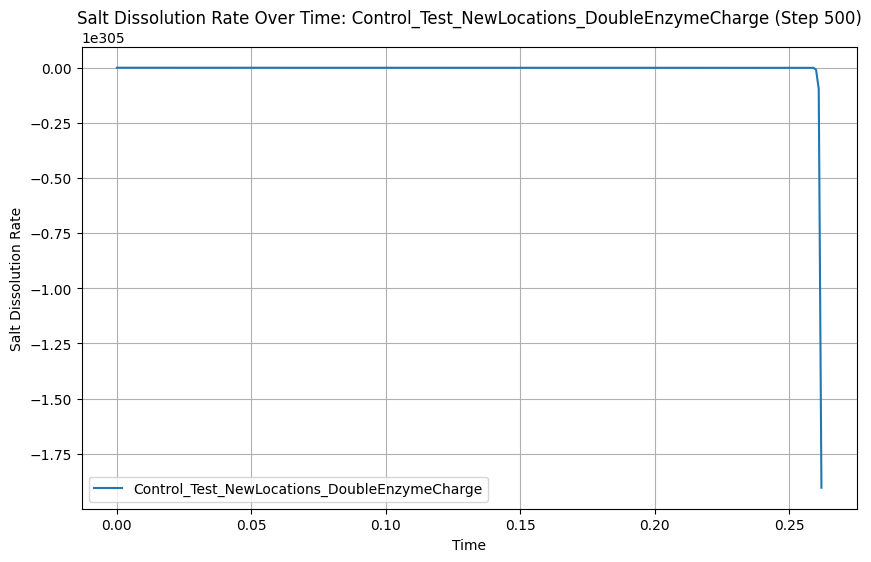

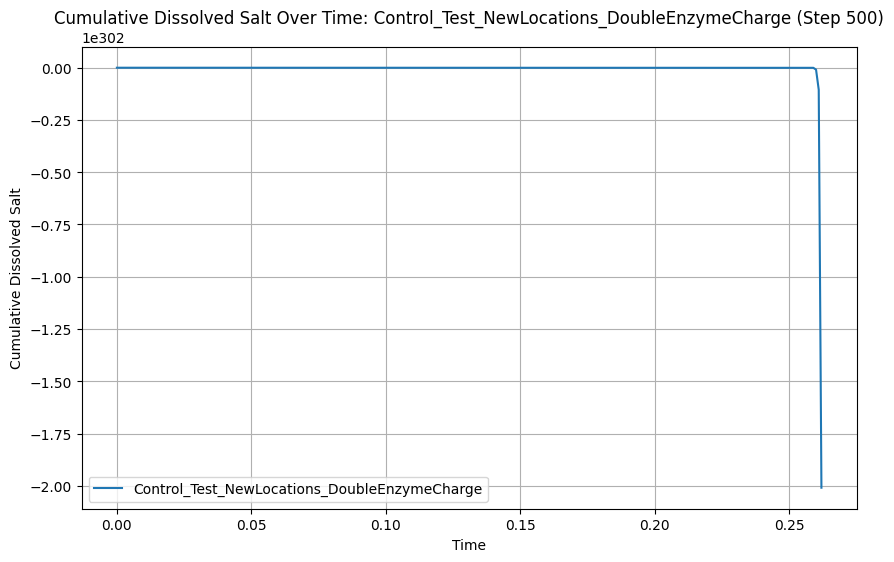

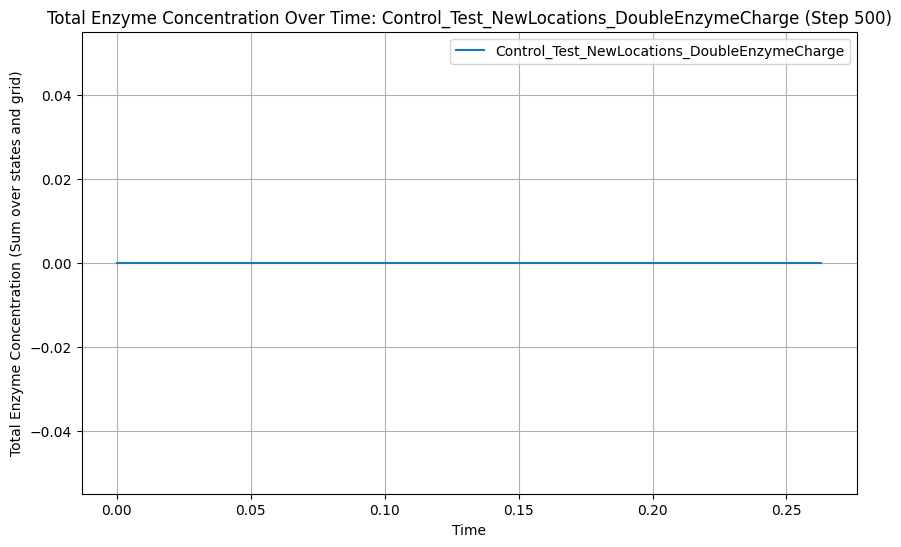

Generating spatial distributions for 'Control_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Control_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Control_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Control_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Pl

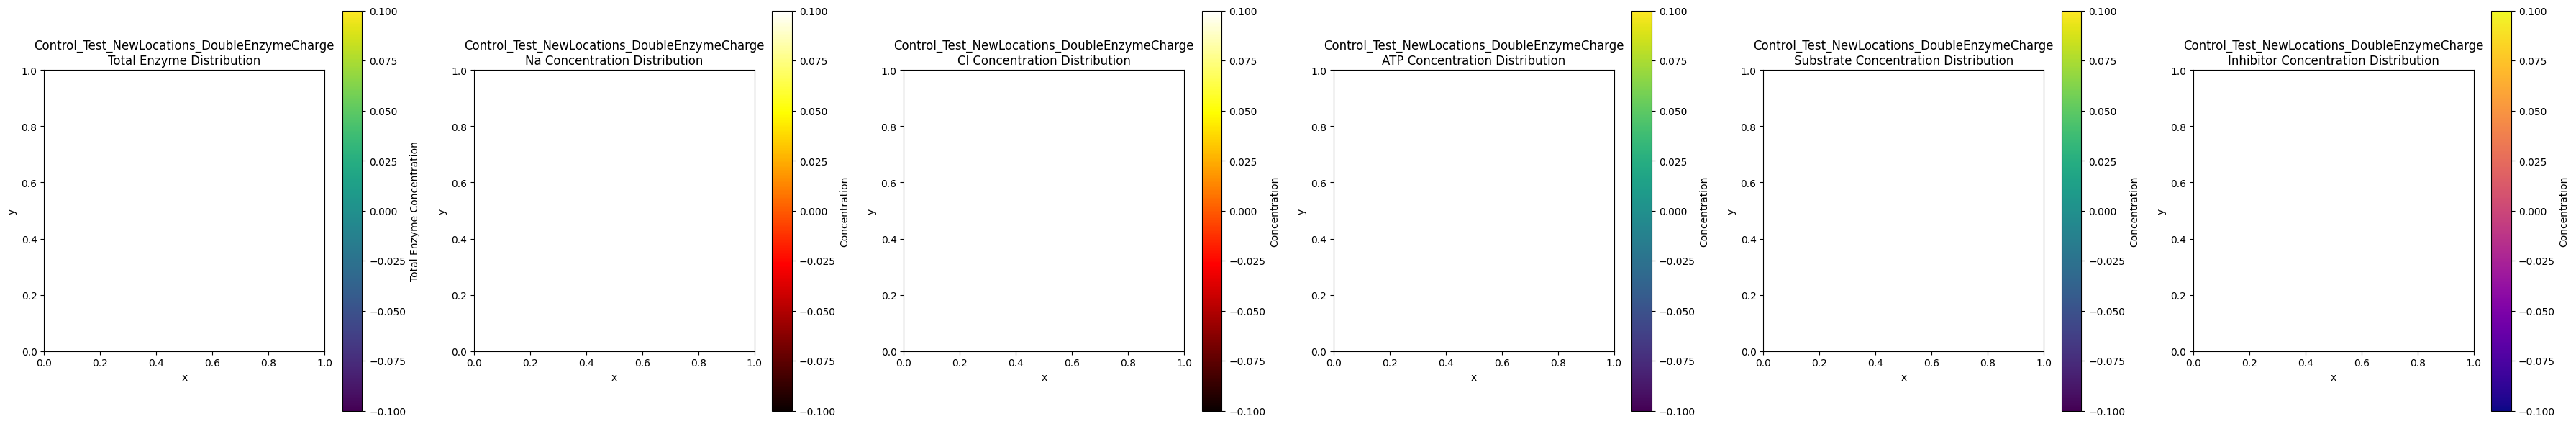

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

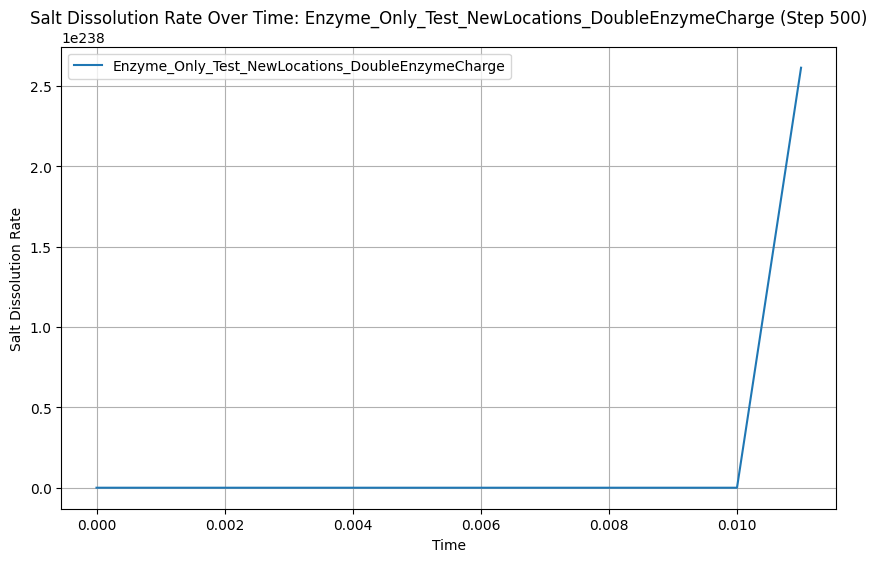

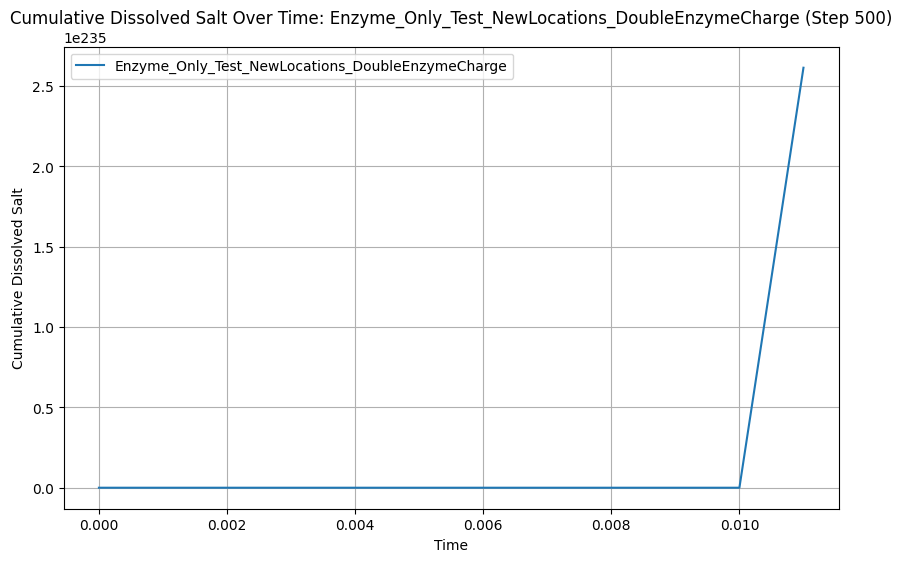

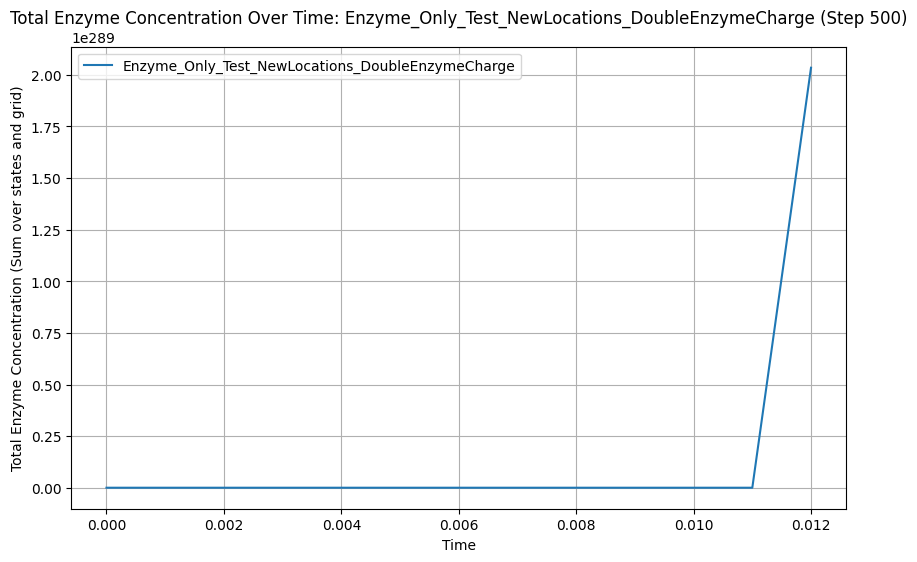

Generating spatial distributions for 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
---------------------

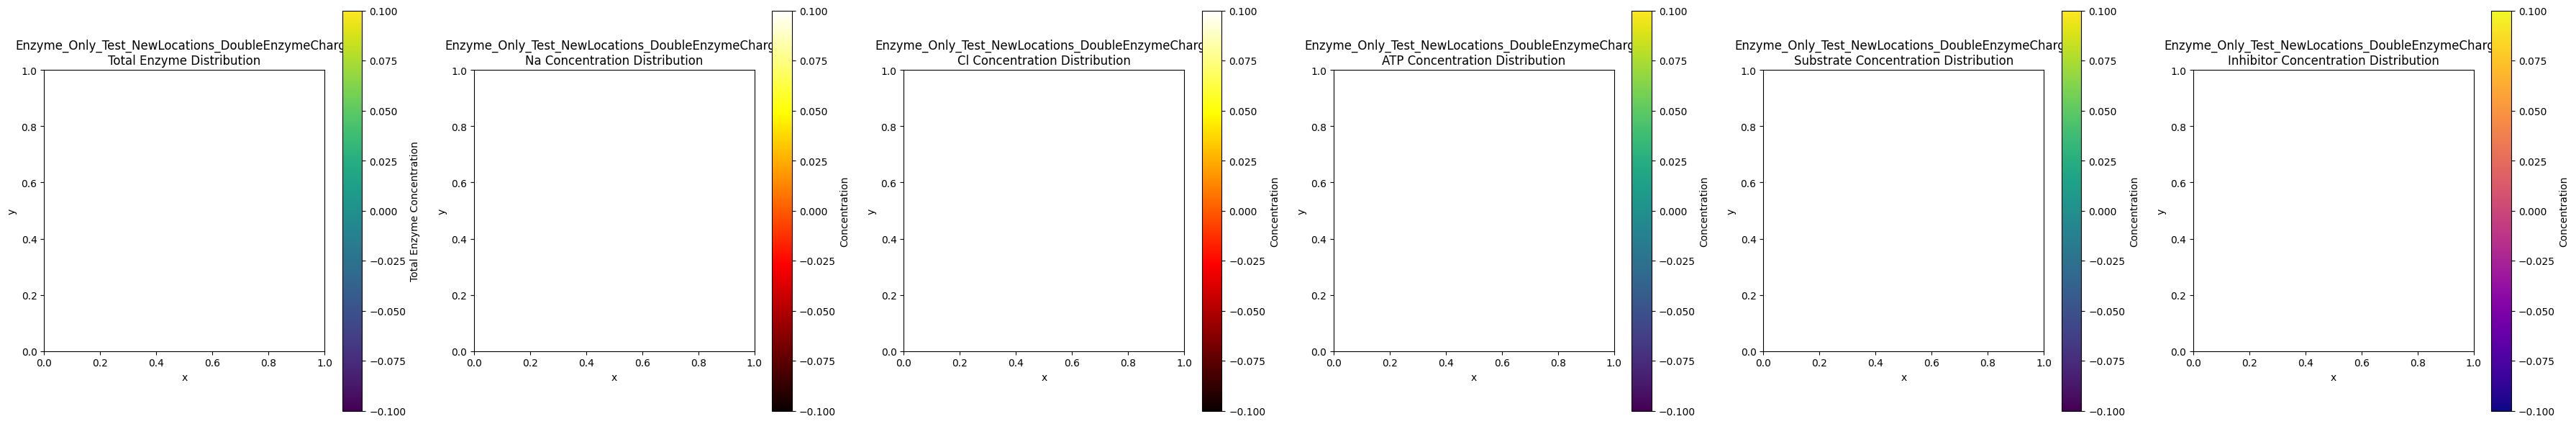

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

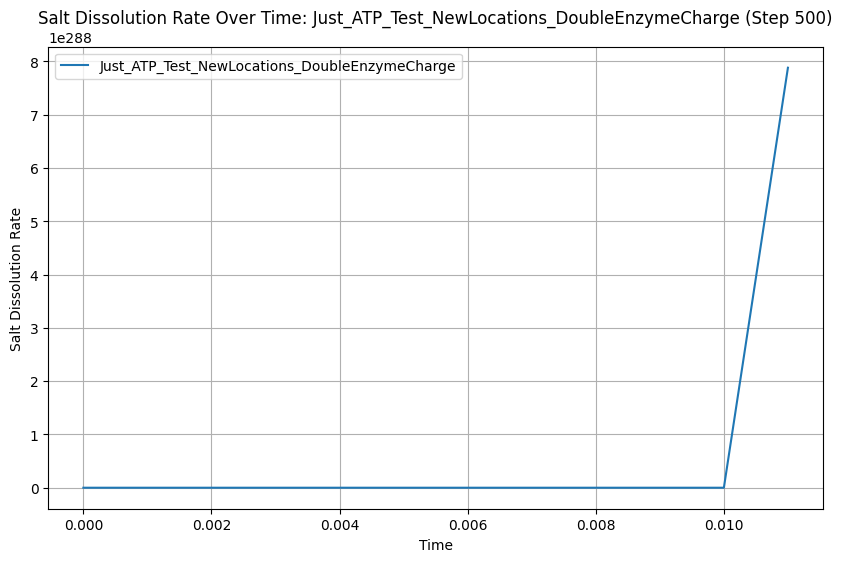

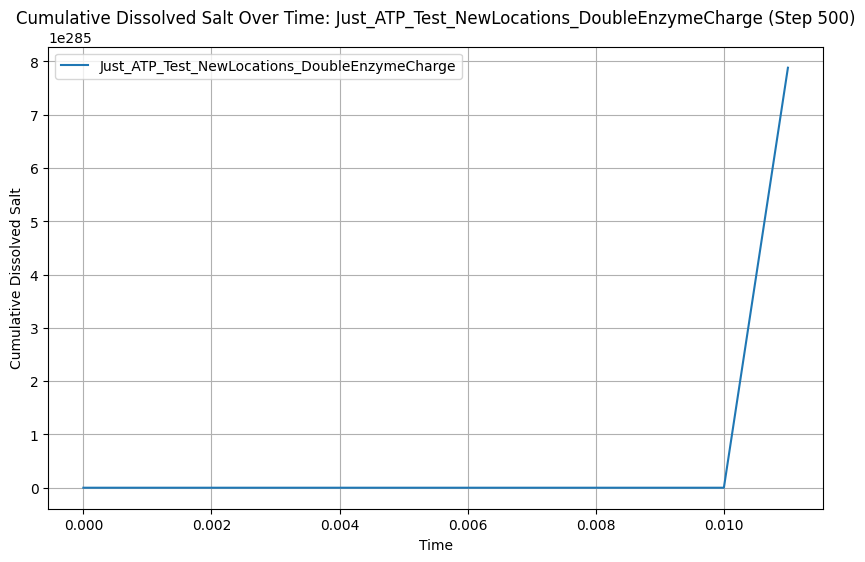

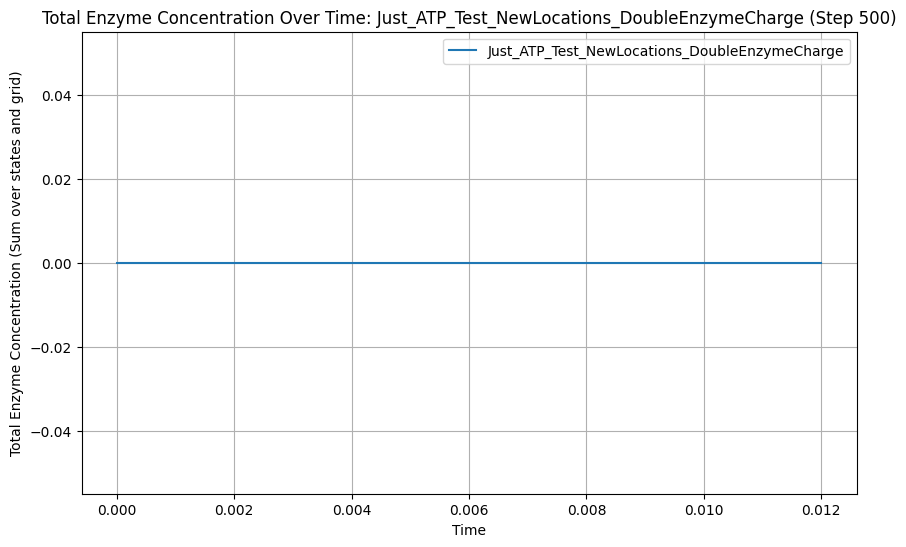

Generating spatial distributions for 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Just_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Just_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Just_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--

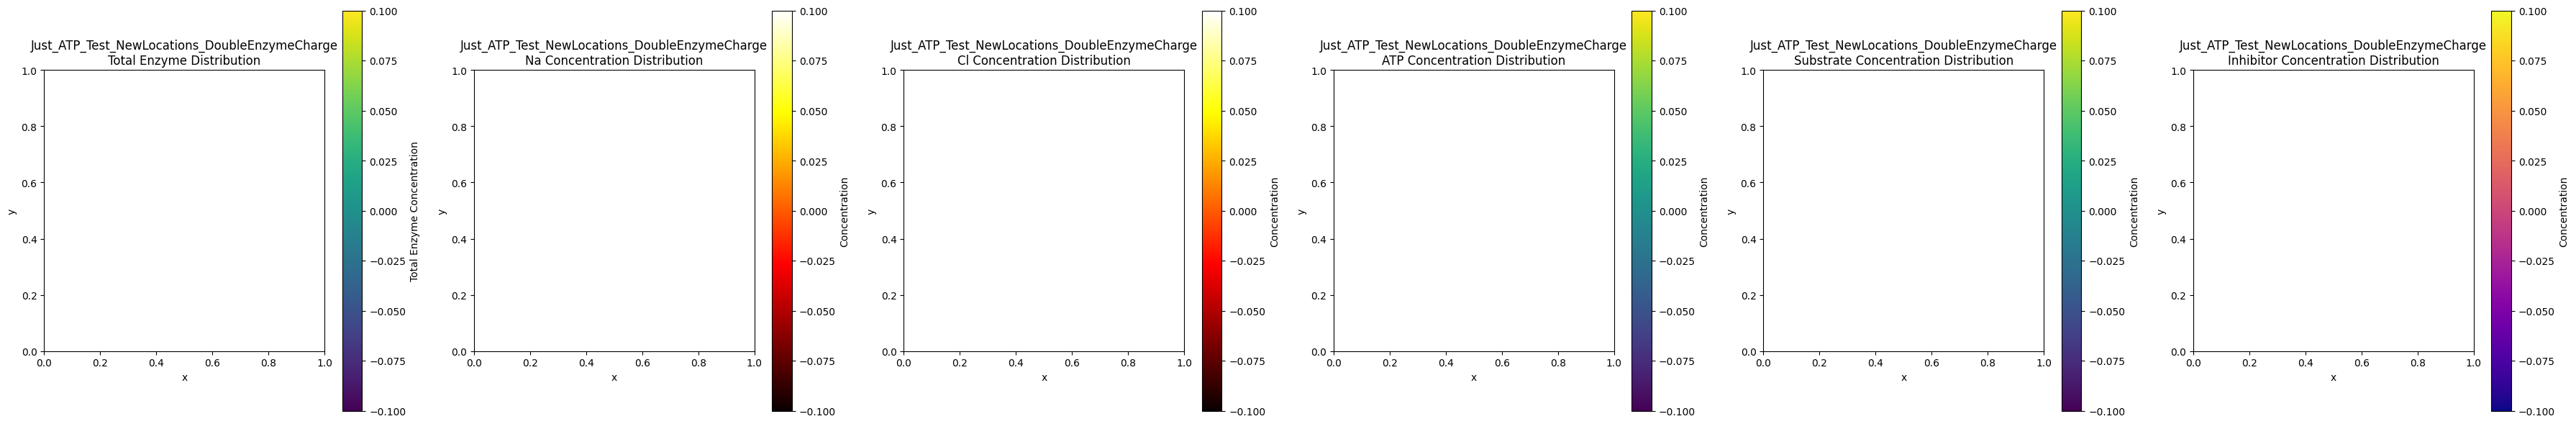

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

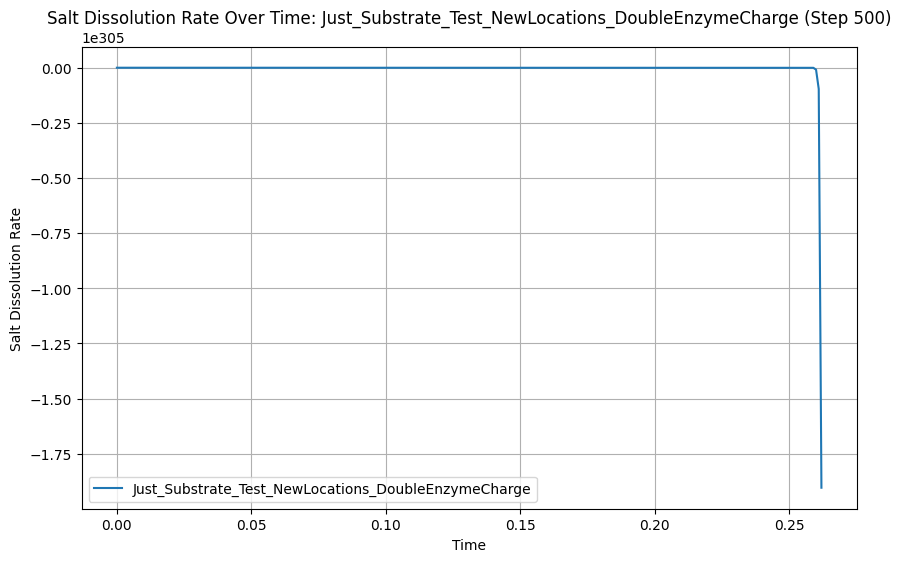

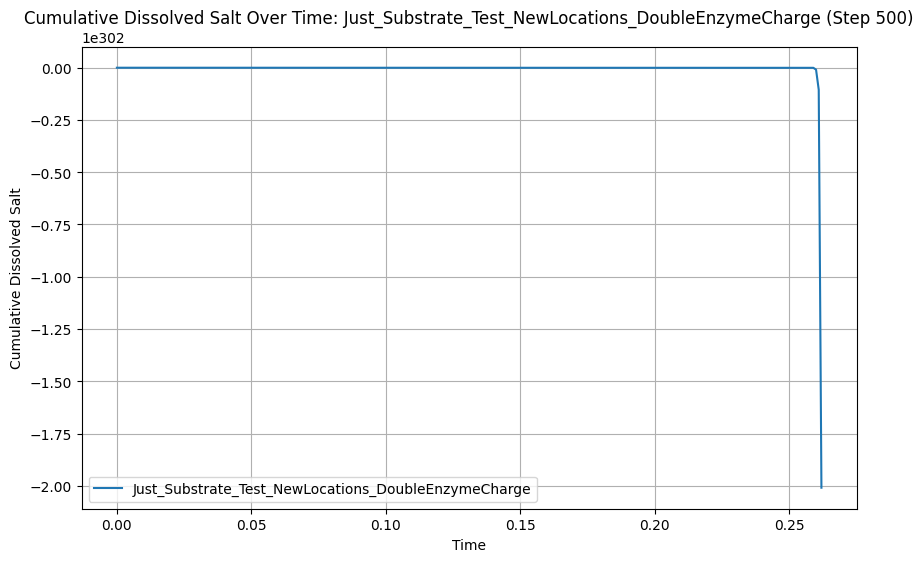

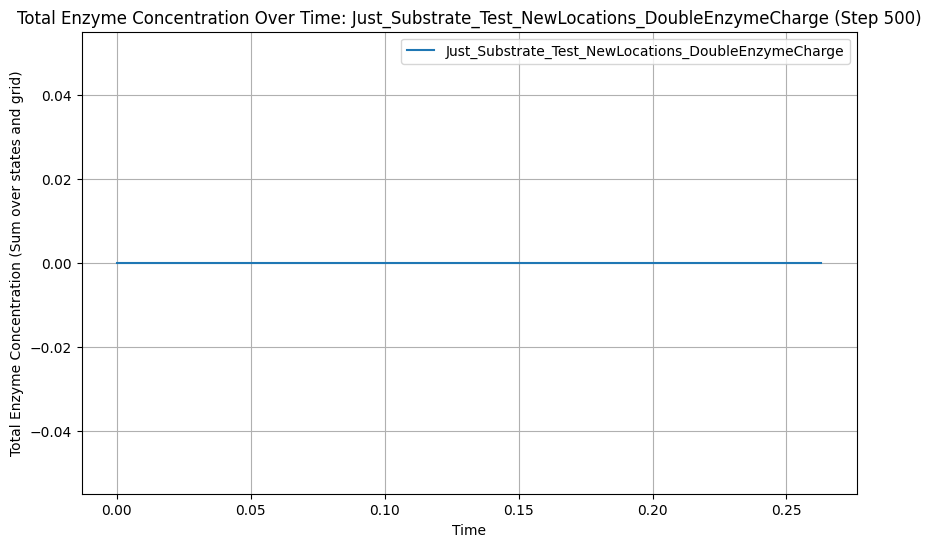

Generating spatial distributions for 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Just_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Just_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Just_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
---------

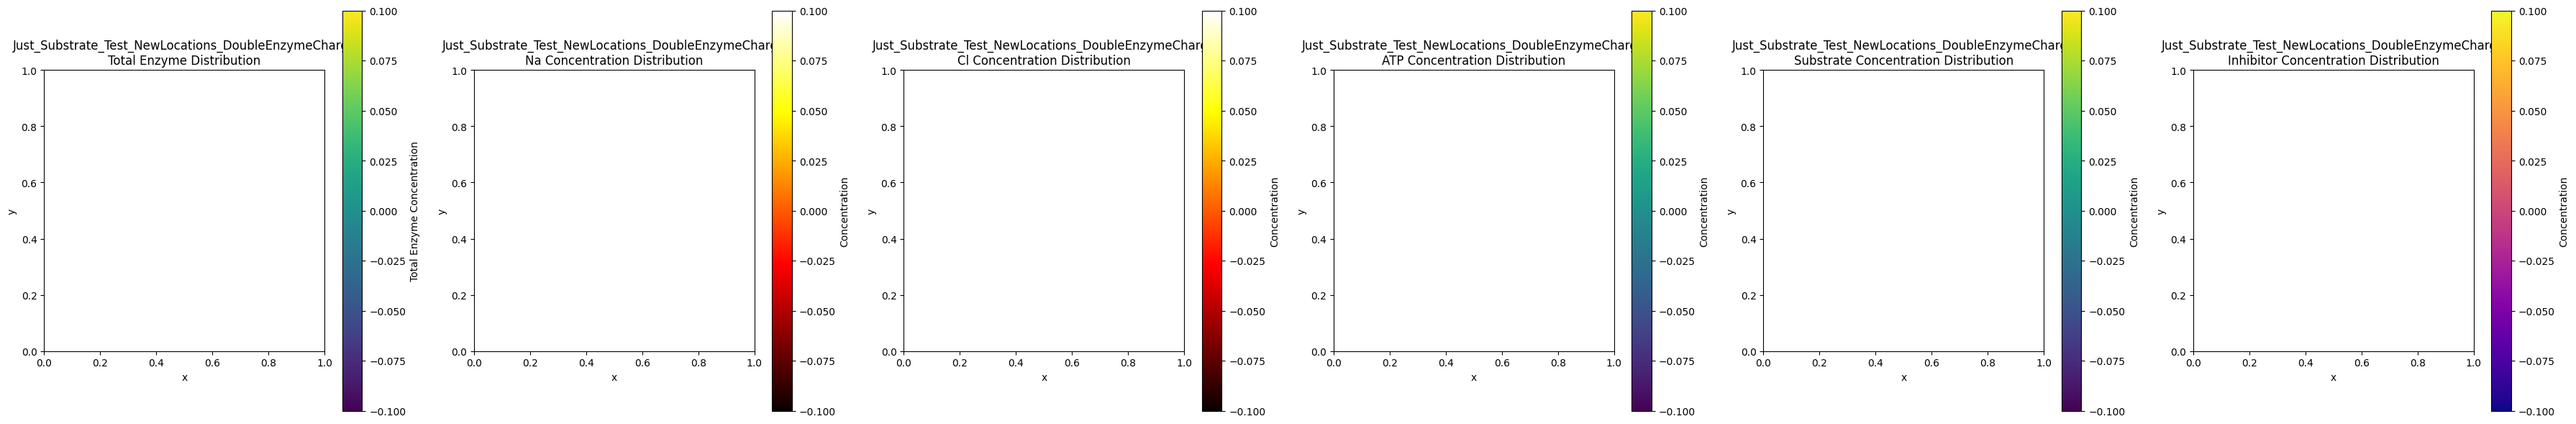

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

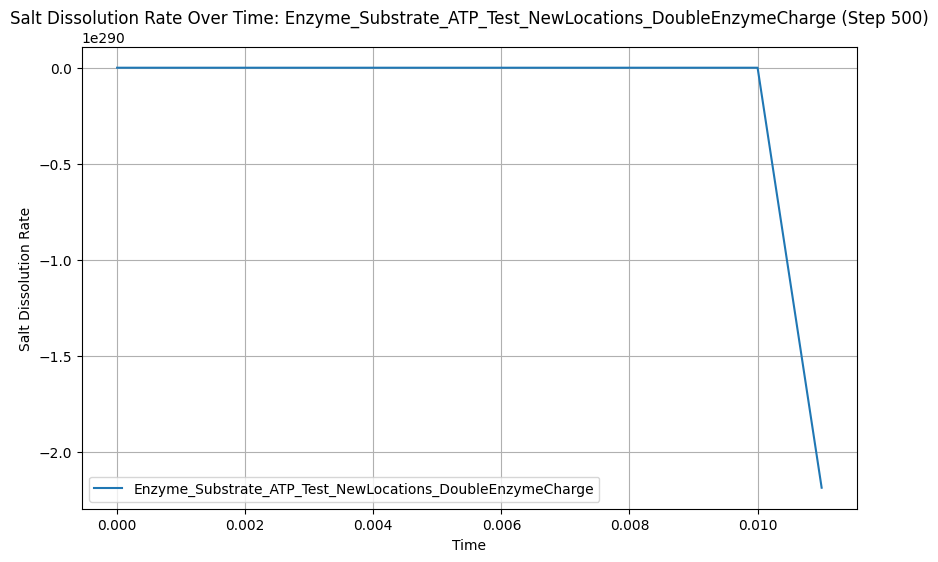

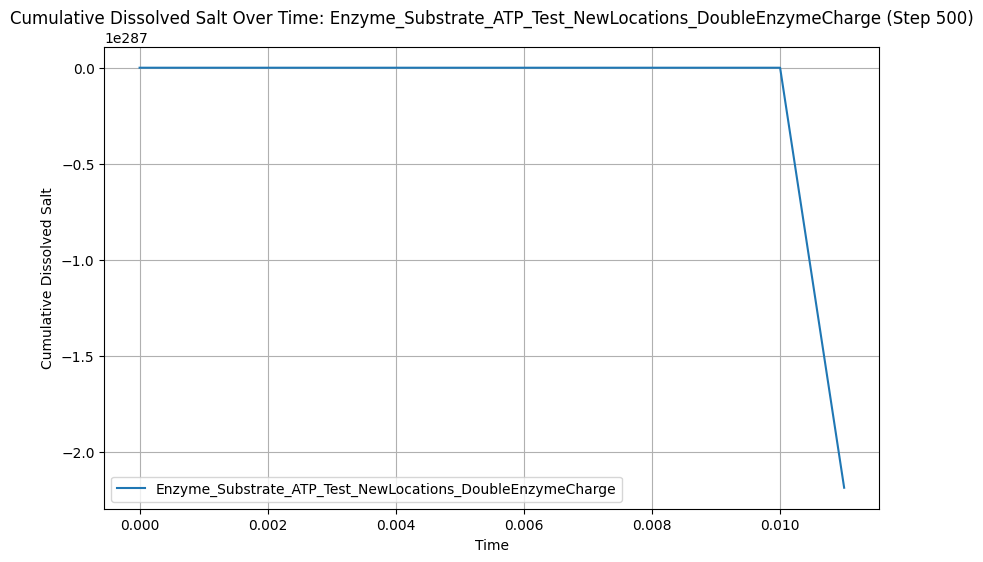

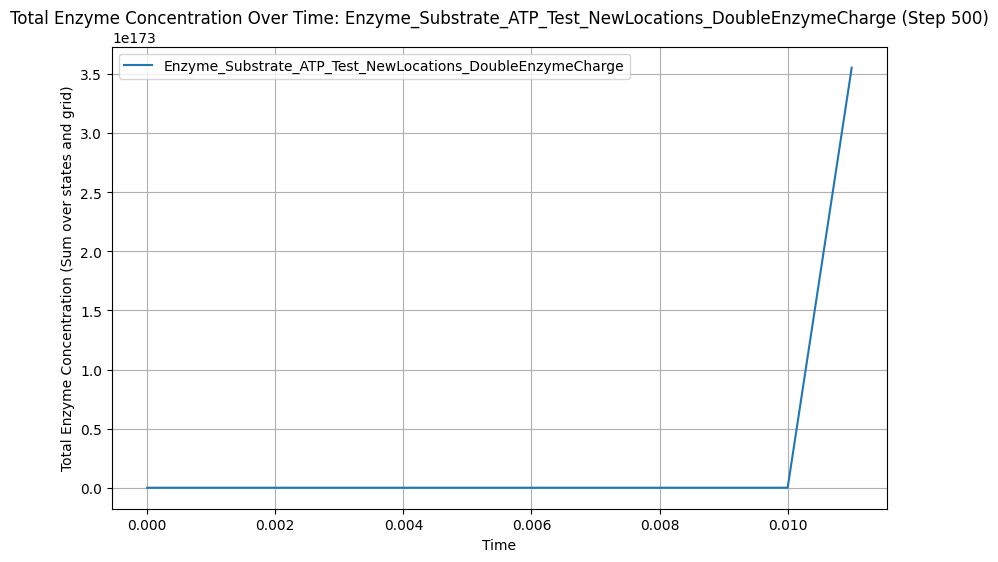

Generating spatial distributions for 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan

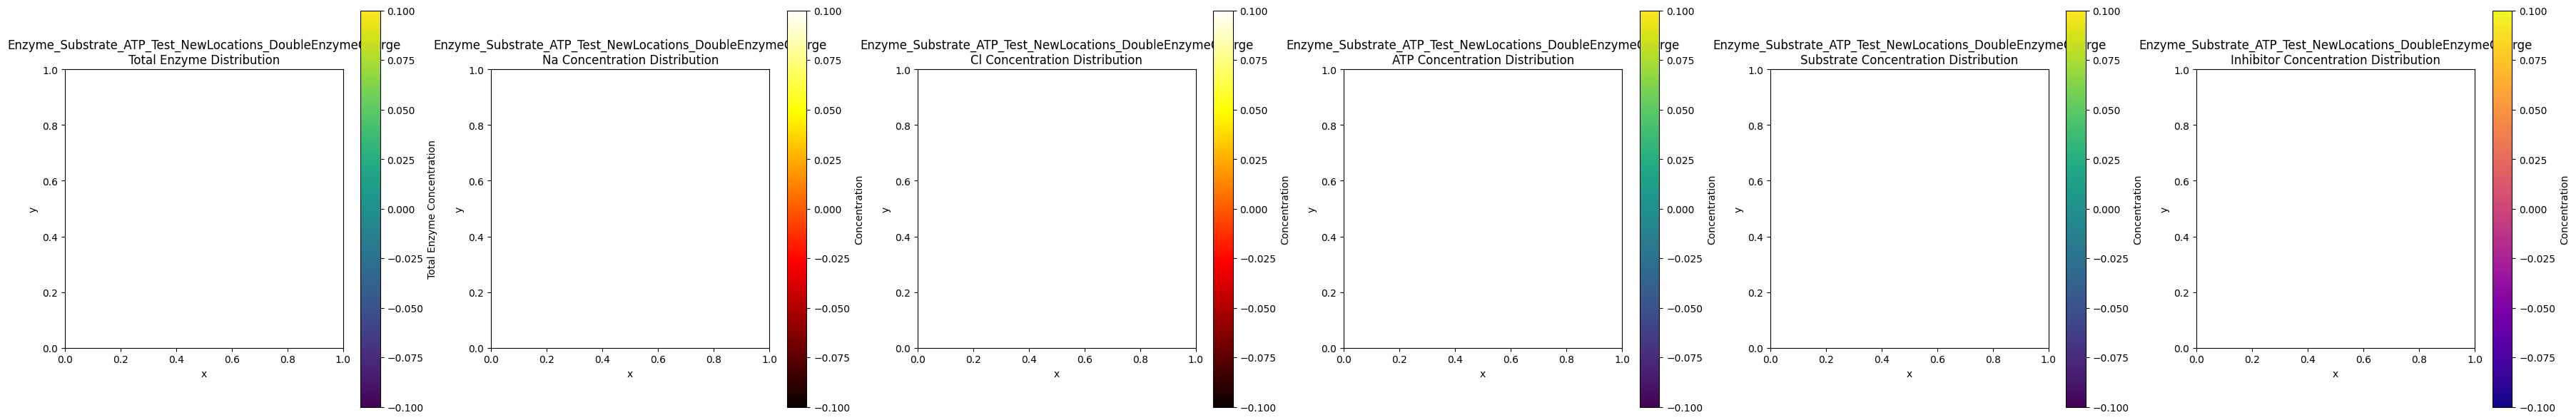

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

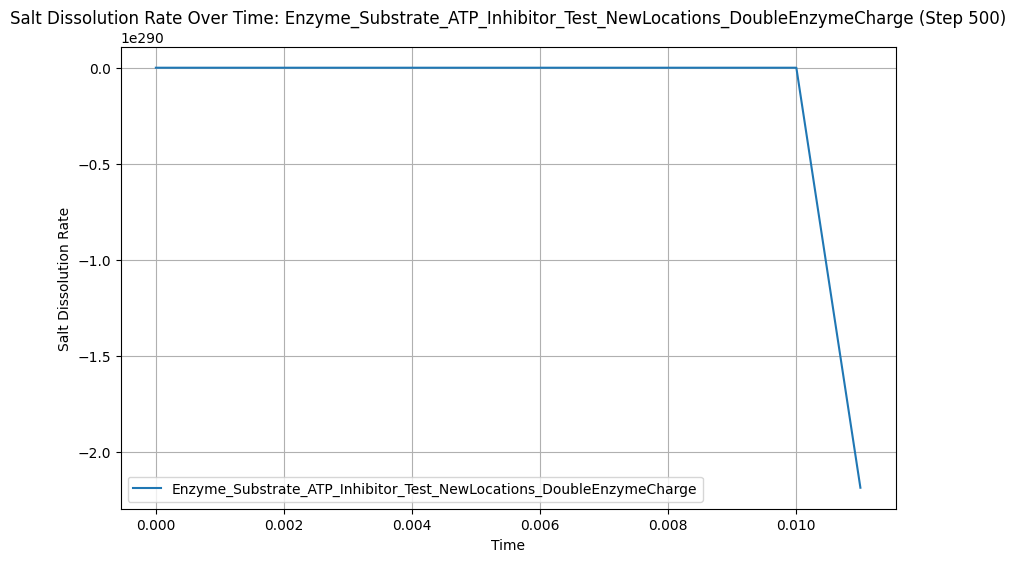

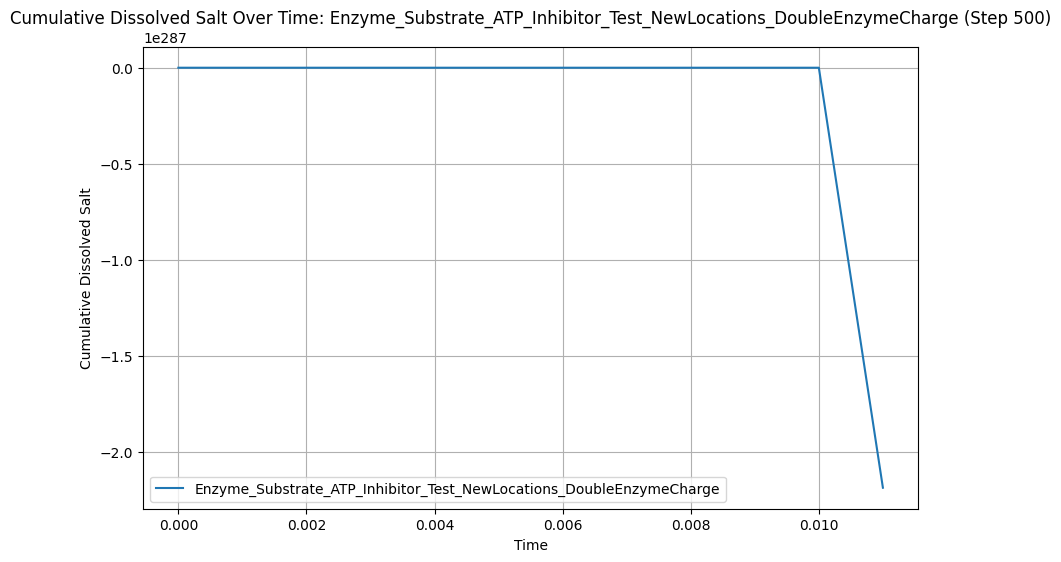

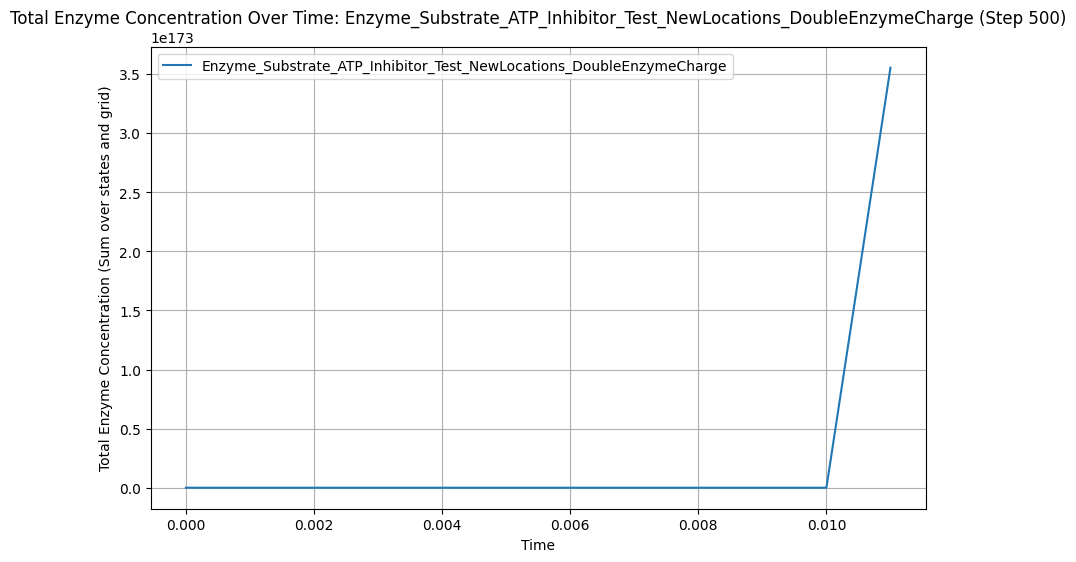

Generating spatial distributions for 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan n

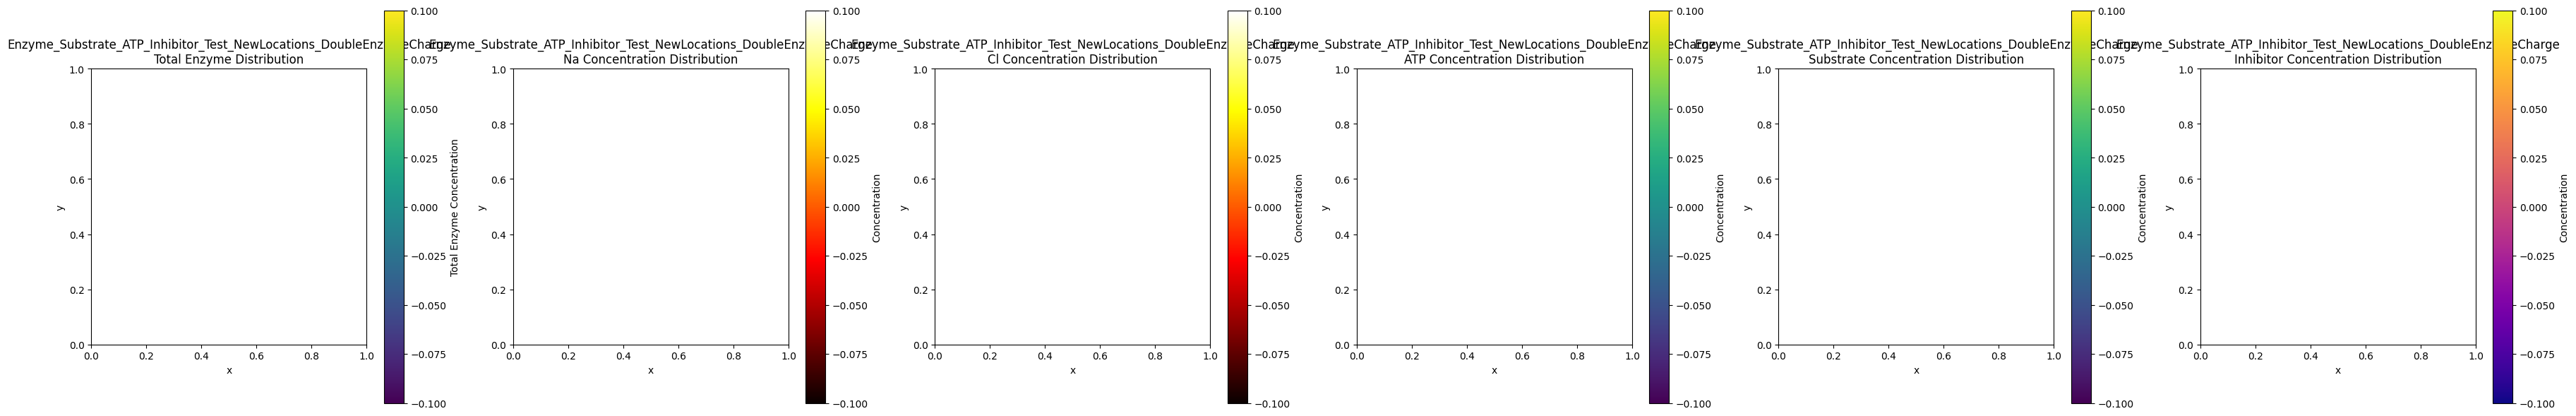

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

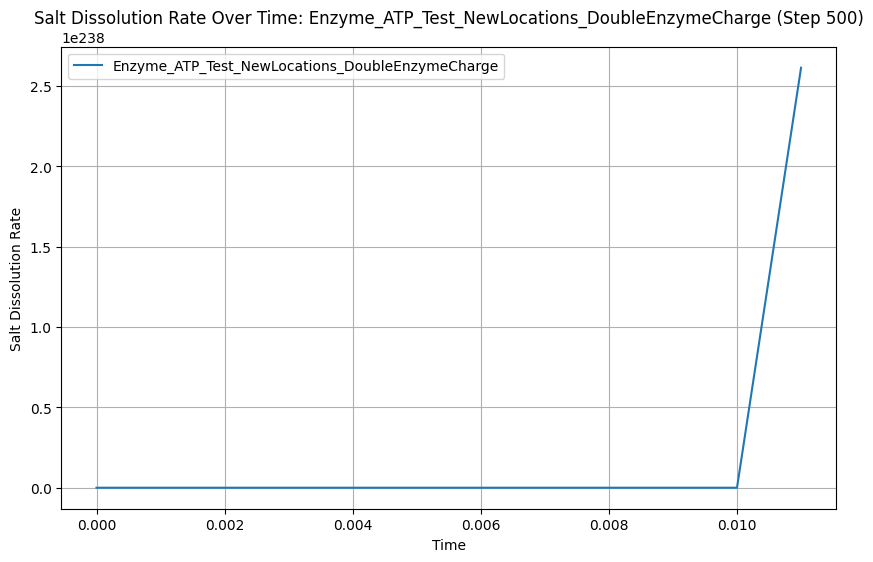

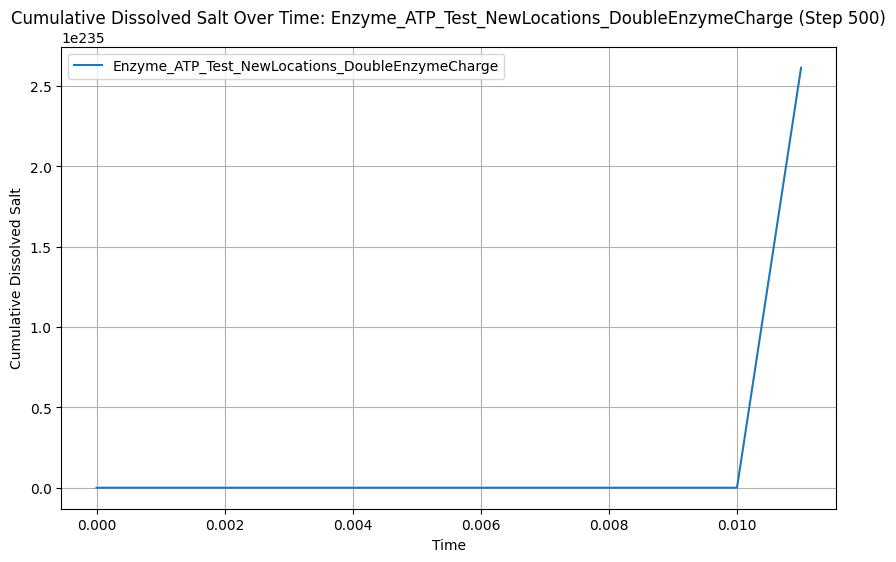

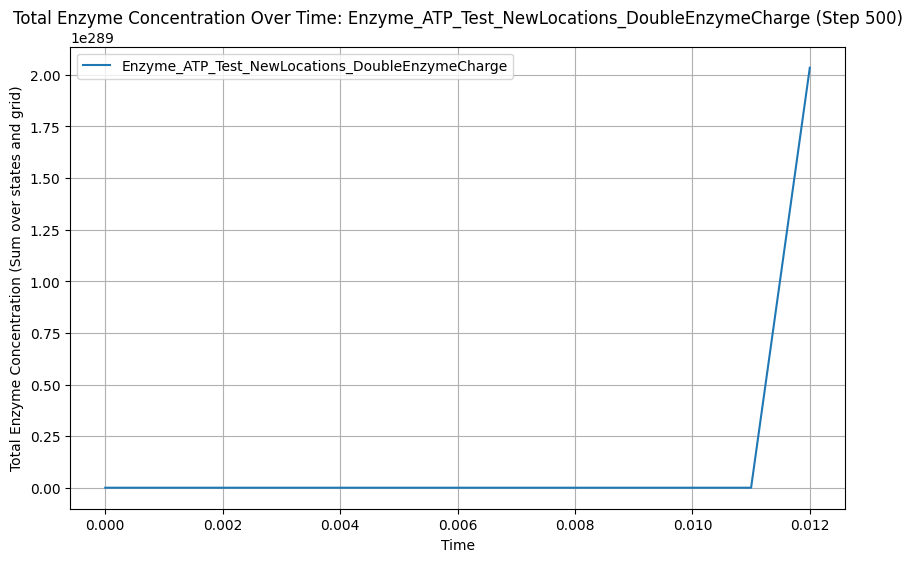

Generating spatial distributions for 'Enzyme_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Enzyme_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Enzyme_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Enzyme_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
-------------------------

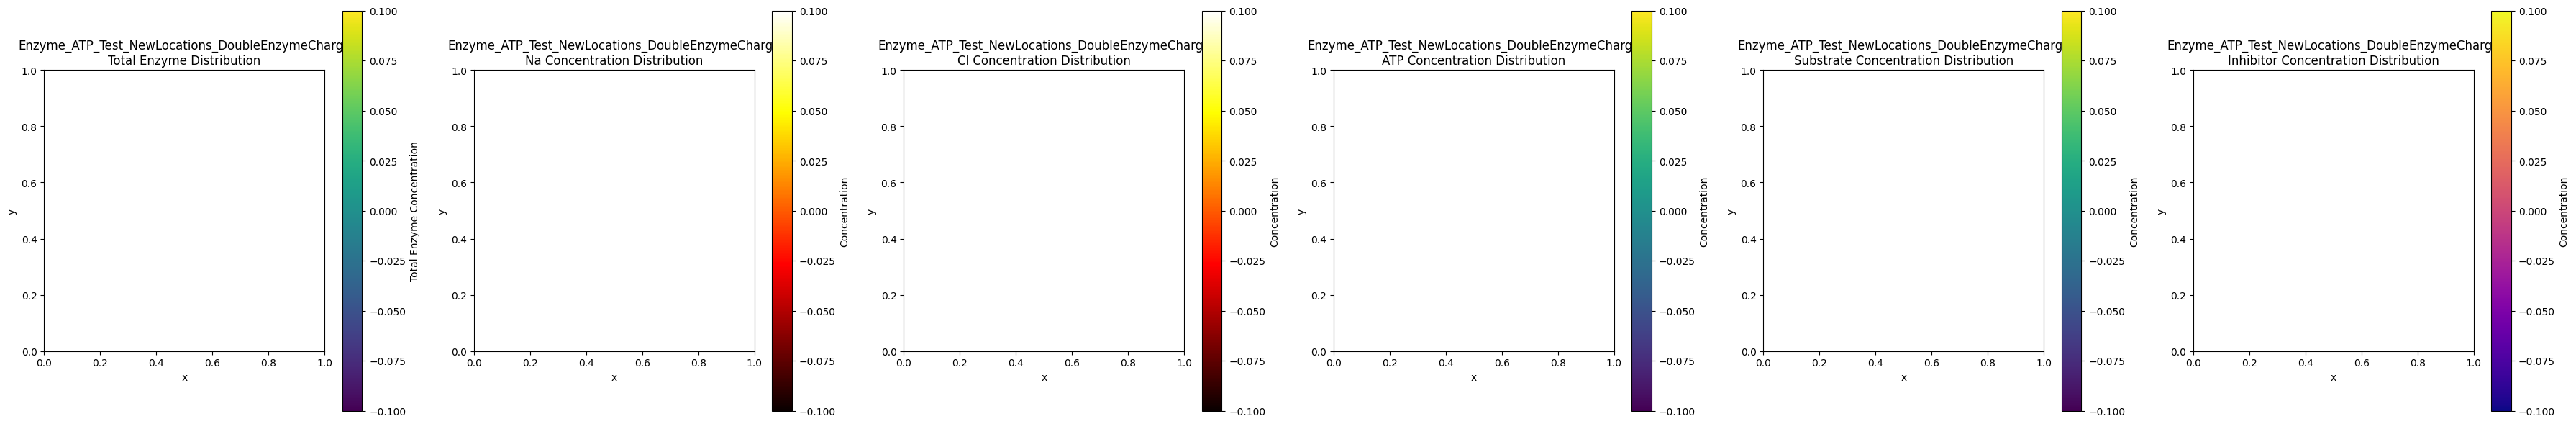

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

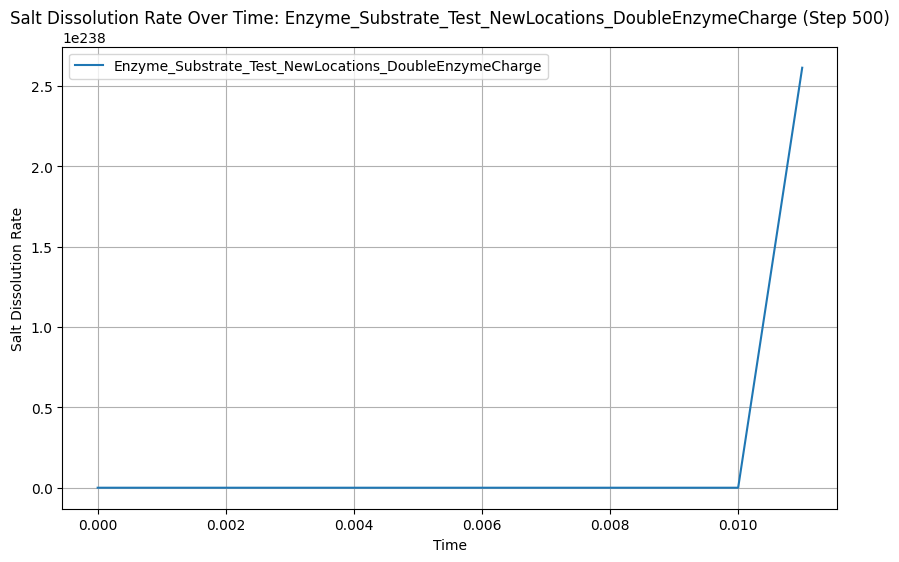

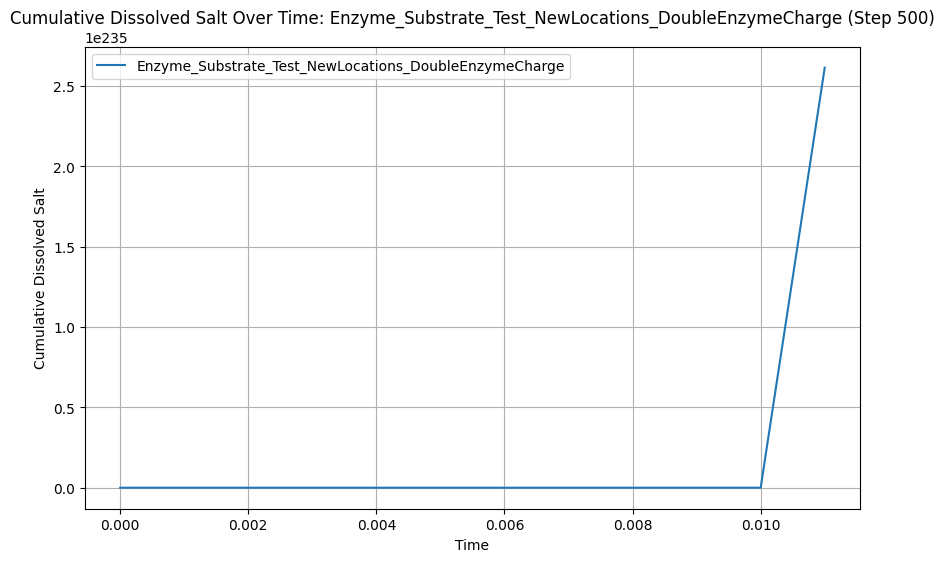

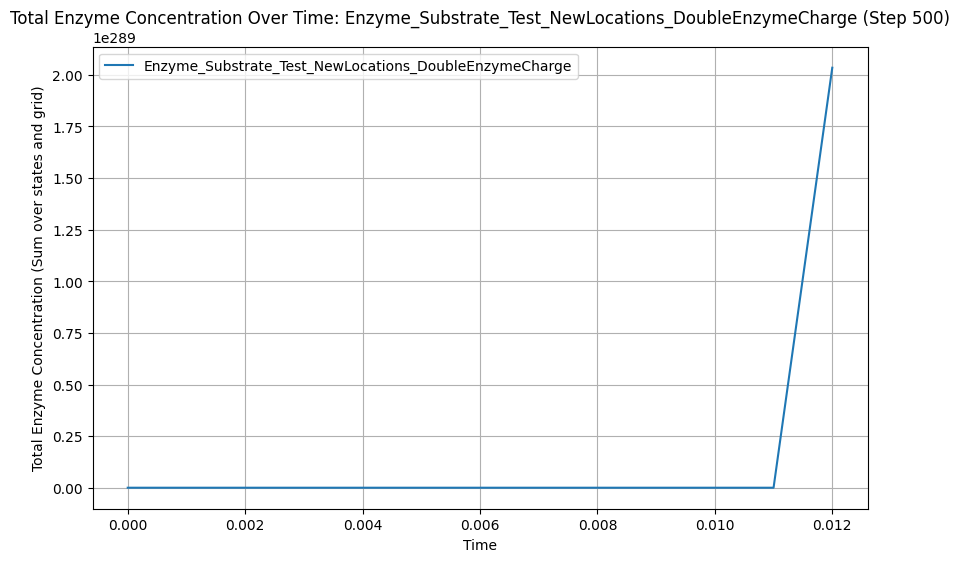

Generating spatial distributions for 'Enzyme_Substrate_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Enzyme_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Enzyme_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Enzyme_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
-

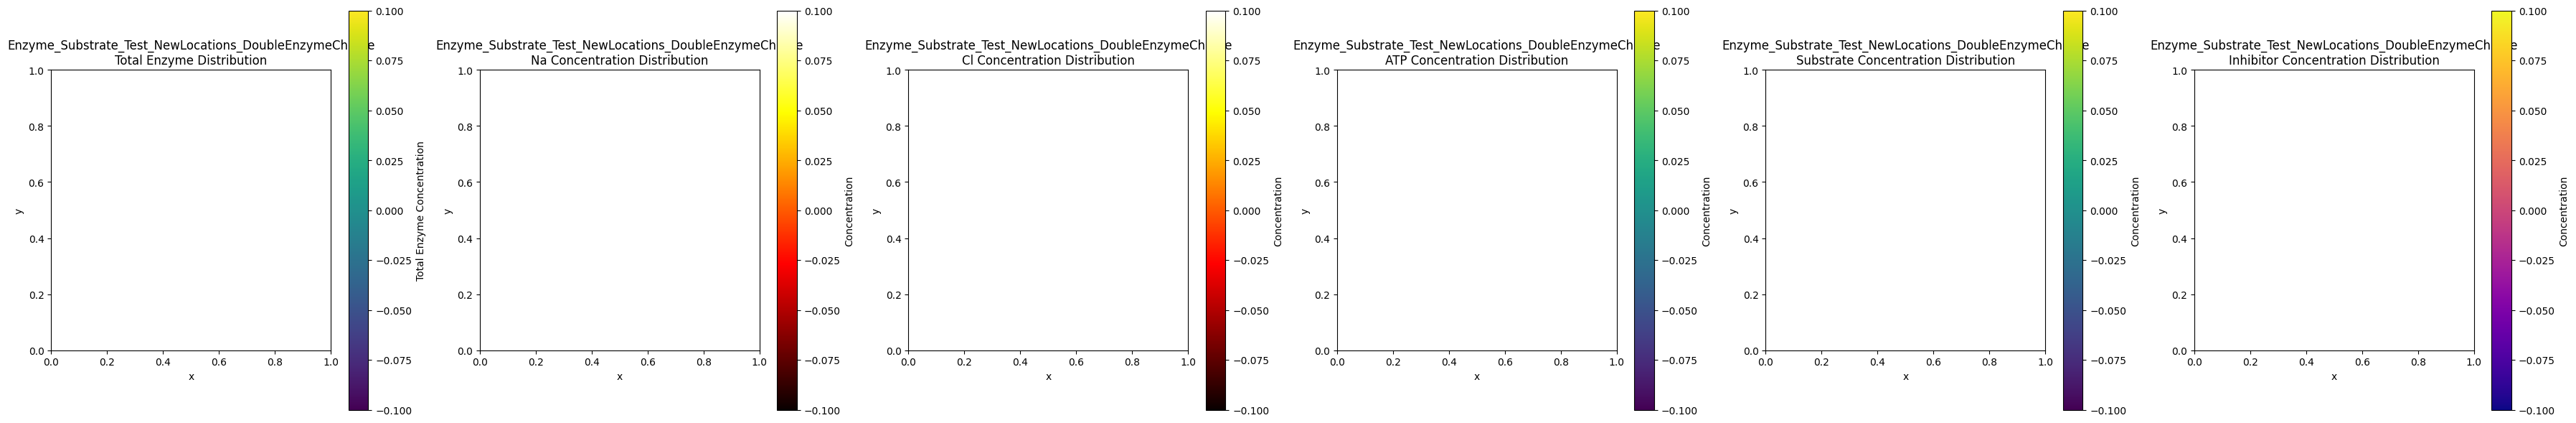

Streaming output truncated to the last 5000 lines.
!!! NaN detected in Enzyme_InhibitorBound concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Substrate concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ATP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in ADP concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Pi concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Inhibitor concentration after Boundary Conditions/Non-negativity at step 437 !!!
!!! NaN detected in Na concentration after Poisson solve at step 438 !!!
!!! NaN detected in Cl concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Free concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_SaltBound concentration after Poisson solve at step 438 !!!
!!! NaN detected in Enzyme_Substrat

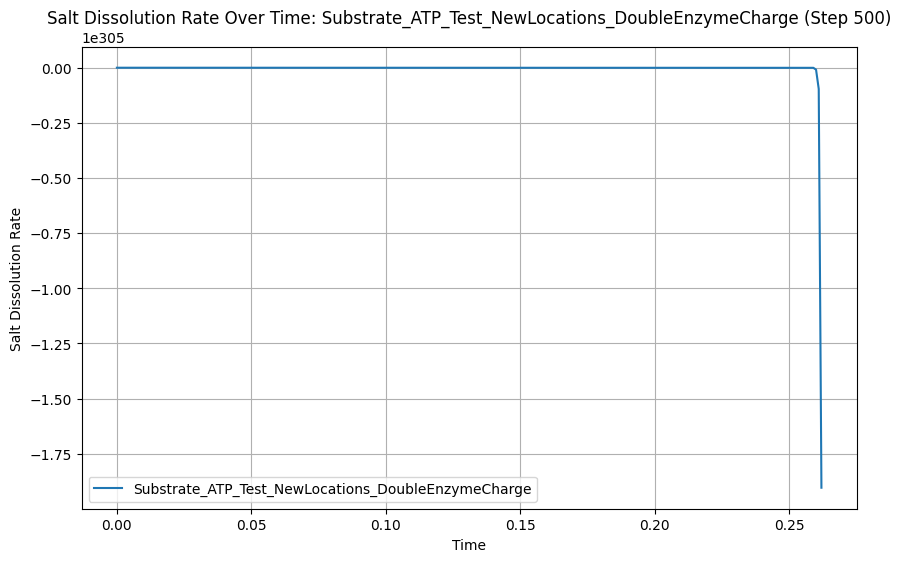

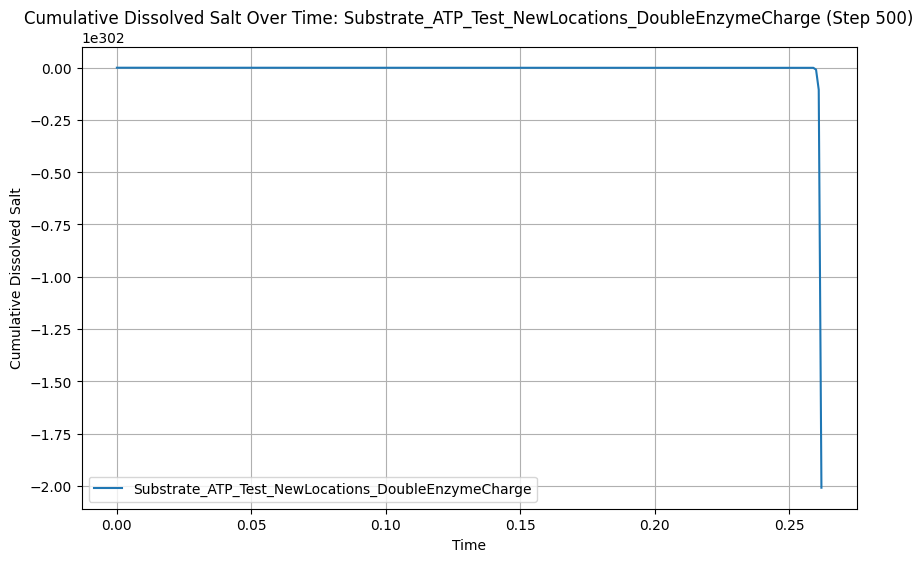

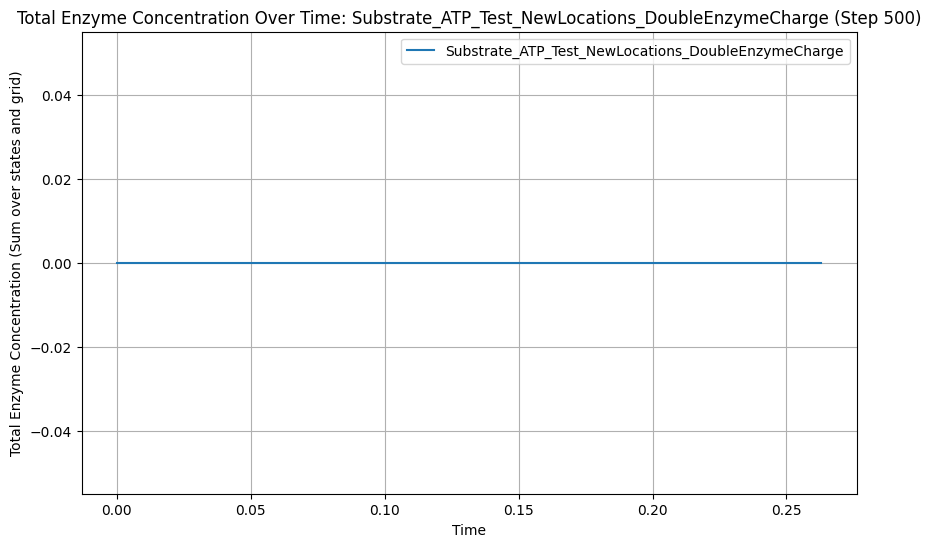

Generating spatial distributions for 'Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...
--- Plotting Total Enzyme for Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Total Enzyme array shape: (100, 100)
Total Enzyme min: nan, max: nan
Total Enzyme first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Na for Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Na array shape: (100, 100)
Na min: nan, max: nan
Na first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
------------------------------
--- Plotting Cl for Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Cl array shape: (100, 100)
Cl min: nan, max: nan
Cl first 5x5 block:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
-------------

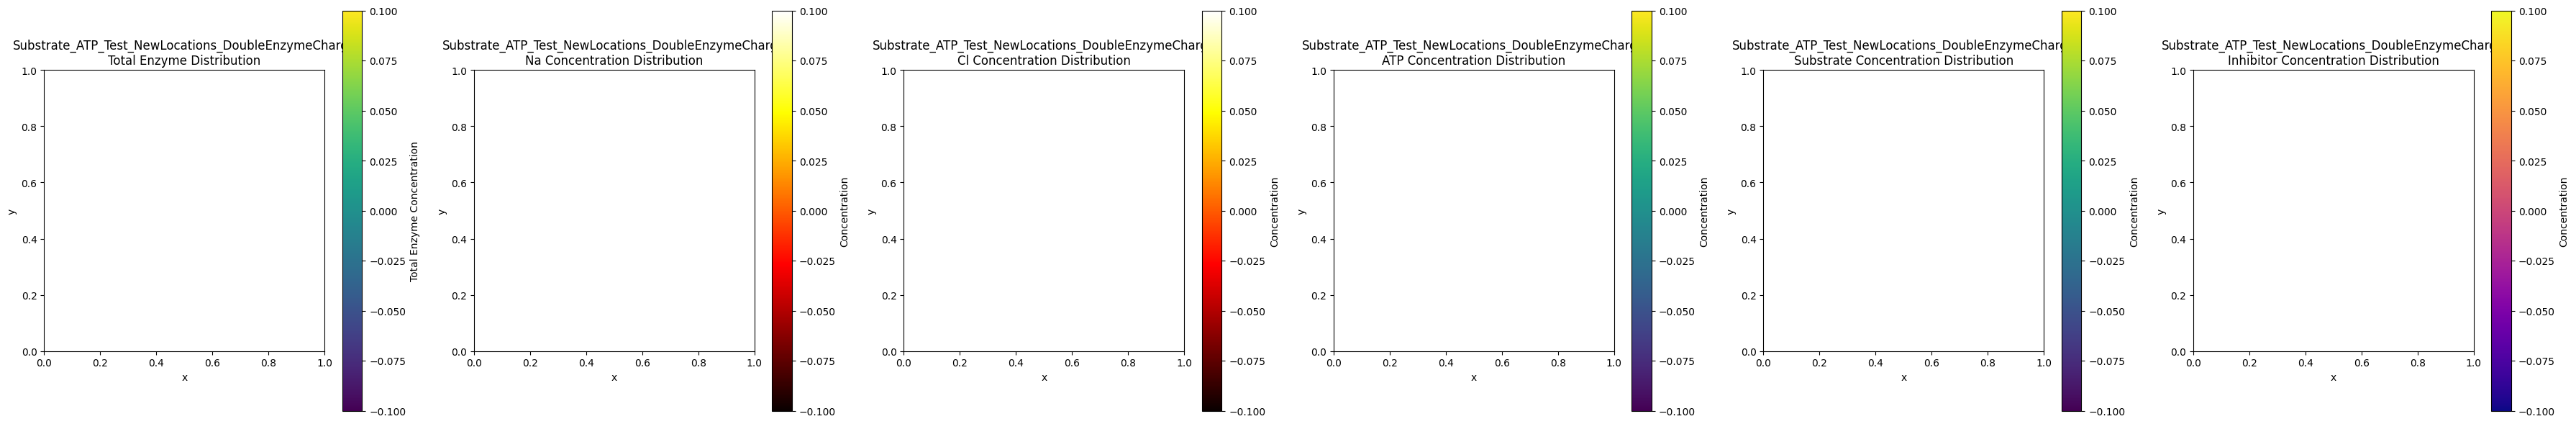

Simulation 'Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge/Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

Short test simulations finished. Review plots above for verification.


In [ ]:
# Cell 4 - Run Short Test Simulations (ID: 4nKUpKq6Beeu)
# This cell runs short test simulations (500 steps) for different conditions to verify the model and GPU solver.

print(f"\nRunning short test simulations ({Nt_test} steps) with updated locations and plotting...")

# Define a flag to control resuming for test runs (usually start from scratch for tests)
resume_test_simulations = False

# 1. Control Simulation (Diffusion + Electrostatics only) - Test Run
initial_concentrations_control_test = create_initial_concentrations(all_species, Ny, Nx)

# Add print statements to check initial concentrations for Control Simulation
print("Checking initial concentrations for Control Simulation:")
# Initialize concentrations based on location arguments (copying logic from run_simulation_condition_with_checkpointing for inspection)
concentrations_check = create_initial_concentrations(all_species, Ny, Nx)
concentrations_check['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
concentrations_check['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
print(f"Initial Na concentration around salt crystal (should be {C_salt_sat}):")
display(concentrations_check['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end])
print(f"Initial Cl concentration around salt crystal (should be {C_salt_sat}):")
display(concentrations_check['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end])
print("-" * 30)


run_simulation_condition_with_checkpointing(
    'Control_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_control_test,
    Nt=Nt_test,
    dt=dt,
    report_interval=100, # More frequent reporting for short run
    checkpoint_interval=Nt_test + 1, # No checkpointing for short test
    plot_interval=Nt_test, # Plot only at the end of the short test
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 2. Enzyme Only Simulation - Test Run
initial_concentrations_enzyme_only_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_only_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 3. Just ATP Simulation - Test Run
initial_concentrations_just_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_ATP_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_just_ATP_test,
    atp_location=atp_initial_location, # Use new ATP location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 4. Just Substrate Simulation (Glucose) - Test Run
initial_concentrations_just_Substrate_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_just_Substrate_test,
    substrate_location=substrate_initial_location, # Use new substrate location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 5. Enzyme + Substrate + ATP Simulation - Test Run
initial_concentrations_enzyme_substrate_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_test, # Corrected to use its own initial concentrations
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 6. Enzyme + Substrate + ATP + Inhibitor Simulation (Example) - Test Run
initial_concentrations_enzyme_substrate_ATP_inhibitor_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_inhibitor_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    inhibitor_location=inhibitor_initial_location, # Use new inhibitor location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 7. Enzyme + ATP Only Simulation - Test Run (New Condition)
initial_concentrations_enzyme_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_ATP_Test_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_ATP_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location,
    atp_location=atp_initial_location, # Only ATP location provided
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 8. Enzyme + Substrate Only Simulation - Test Run (New Condition)
initial_concentrations_enzyme_substrate_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_Test_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location,
    substrate_location=substrate_initial_location, # Only Substrate location provided
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 9. Substrate + ATP Only Simulation - Test Run (New Condition)
initial_concentrations_substrate_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_substrate_ATP_test,
    atp_location=atp_initial_location,
    substrate_location=substrate_initial_location, # Substrate and ATP locations provided
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


print("\nShort test simulations finished. Review plots above for verification.")

In [ ]:
# Cell 5: Run Full Simulations (5000 steps)

print(f"\nRunning full simulations ({Nt} steps) with updated locations and plotting...")

# Define a master switch for resuming full simulations
resume_full_simulations = False # Set to True to resume from the latest checkpoint for all conditions

# 1. Control Simulation (Diffusion + Electrostatics only) - Full Run
initial_concentrations_control_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Control_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_control_full,
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 2. Enzyme Only Simulation - Full Run
initial_concentrations_enzyme_only_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Only_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_only_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 3. Just ATP Simulation - Full Run
initial_concentrations_just_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_just_ATP_full,
    atp_location=atp_initial_location, # Use new ATP location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)


# 4. Just Substrate Simulation (Glucose) - Full Run
initial_concentrations_just_Substrate_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_Substrate_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_just_Substrate_full,
    substrate_location=substrate_initial_location, # Use new substrate location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)


# 5. Enzyme + Substrate + ATP Simulation - Full Run
initial_concentrations_enzyme_substrate_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 6. Enzyme + Substrate + ATP + Inhibitor Simulation (Example) - Full Run
initial_concentrations_enzyme_substrate_ATP_inhibitor_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Inhibitor_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_inhibitor_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    inhibitor_location=inhibitor_initial_location, # Use new inhibitor location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 7. Enzyme + ATP Only Simulation - Full Run (New Condition)
initial_concentrations_enzyme_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_ATP_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location,
    atp_location=atp_initial_location, # Only ATP location provided
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 8. Enzyme + Substrate Only Simulation - Full Run (New Condition)
initial_concentrations_enzyme_substrate_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location,
    substrate_location=substrate_initial_location, # Only Substrate location provided
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)

# 9. Substrate + ATP Only Simulation - Full Run (New Condition)
initial_concentrations_substrate_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Substrate_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_substrate_ATP_full,
    atp_location=atp_initial_location,
    substrate_location=substrate_initial_location, # Substrate and ATP locations provided
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy, # Pass dx and dy here
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat, Lx=Lx, Ly=Ly # Pass Lx and Ly here
)


print("\nFull simulations finished.")

NameError: name 'Nt' is not defined